<a href="https://colab.research.google.com/github/hochschule-pforzheim/project-st23-team-b23/blob/main/Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gradient Boosting


In diesem Notebook tranieren wir ein Gradient Boosting Modell auf unsere Daten

Leonie

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

Modell 1 und 2 wurde mit den nicht guppierten Daten erstellt und ist daher nur ein Versuch, der jedoch nicht richtig ist. Später haben wir den Fehler bemerkt und die Modelle mit den nach dem Filmtitel gruppieren Daten traniert

#Modell 1 und 2

##Modell 1

In [2]:
df = pd.read_csv('/content/Daten_kodiert_fuer_modelle_dummykodierung_V3.csv')

In [3]:
#Als erstes bestimmen wir X und Y und führen den Train Test Split durch

X = df.drop(columns=['target_variable', 'title', 'description', 'character'])

y = df['target_variable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#Als nächstes definieren, tranieren und evaluieren unser Modell

gbr = GradientBoostingRegressor(random_state=42)

In [5]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
def evaluate(reg, X_test, y_test):
  pred = reg.predict(X_test)
  print('R2:', r2_score(y_test, pred))
  print('MAE:', mean_absolute_error(y_test, pred))
  print('MSE:', mean_squared_error(y_test, pred))
  print('RMSE:', mean_squared_error(y_test, pred, squared=False))
  print('MAPE:', mean_absolute_percentage_error(y_test, pred))

In [7]:
evaluate(gbr, X_test, y_test)

R2: 0.5120310797305563
MAE: 0.536239481411044
MSE: 0.5005399756578129
RMSE: 0.7074884986046155
MAPE: 0.08903579190521772


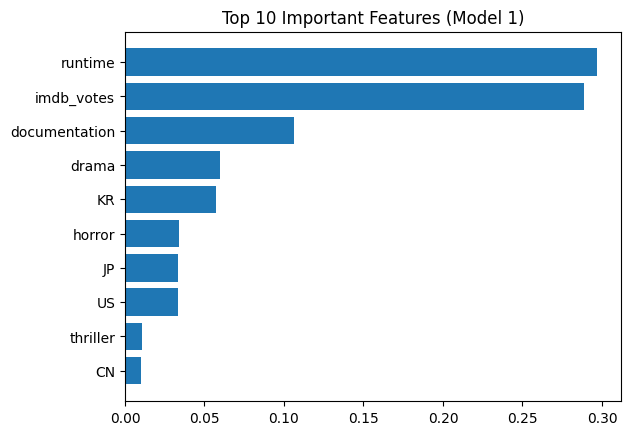

In [8]:
#Schauen wir uns an welche Feature in unserem Modell am wichtigsten sind:

feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_10 = 10
pos = np.arange(top_10)
plt.barh(pos, feature_importance[sorted_idx][-top_10:], align='center')

plt.yticks(pos, np.array(X.columns)[sorted_idx][-top_10:])
plt.title('Top 10 Important Features (Model 1)')
plt.show()

Wir sehen, dass in dem Modell die runtime und die imdb votes die wichtigsten features sind. Auch das genre und die Produktionsländer sind ausschlaggebend. Wir führen Hyperparameter Tuning durch, um die Performace zu verbessern

###Hyperparameter Tuning

In [9]:
parameter_grid = {'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001],
                  'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750],
                  'max_depth': [2, 3, 4, 5, 6, 7]}

In [10]:
optimized_gbr = RandomizedSearchCV(gbr, parameter_grid, n_iter=5, n_jobs=-1, random_state=42, verbose=3)
optimized_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000, 1250, 1500,
                                                         1750]},
                   random_state=42, verbose=3)

In [11]:
optimized_gbr.best_params_

{'n_estimators': 1250, 'max_depth': 7, 'learning_rate': 0.15}

In [12]:
evaluate(optimized_gbr, X_test, y_test)

R2: 0.9875666107470478
MAE: 0.029490843714367842
MSE: 0.012753698228527345
RMSE: 0.11293227275020788
MAPE: 0.00472453223032832


Nach dem Hyperparameter Tuning funktioniert unser Modell deutlich besser

In [13]:
best_gbr = optimized_gbr.best_estimator_

###Error Analyse

In [14]:
#Als erstes überprüfen wir ob overfitting vorliegt

In [15]:
best_gbr = optimized_gbr.best_estimator_
predictions = best_gbr.staged_predict(X_test)
n_estimators = optimized_gbr.best_params_['n_estimators']

test_score = np.zeros((n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(predictions):
    test_score[i] = best_gbr.loss_(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


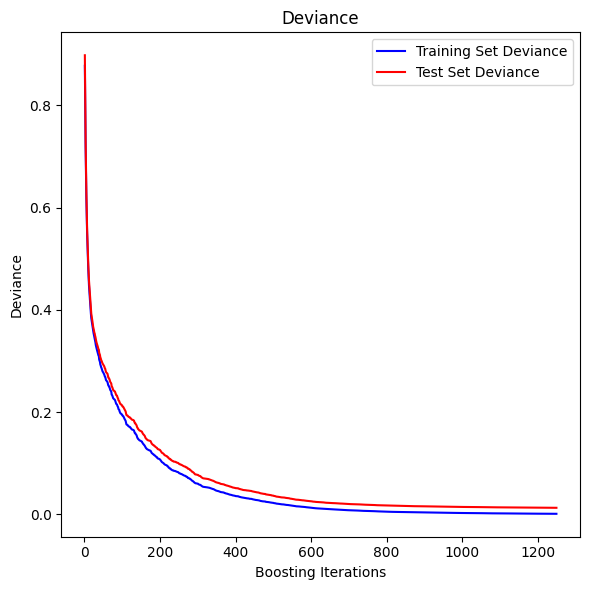

In [16]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(n_estimators) + 1, best_gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

Wir sehen, das Modell funktioniert wie zu erwarten für die Trainingsdaten besser als für die Testdaten. Bei circa 300 Iterationen wird das Modell nicht mehr besser. Wir sehen kein starkes Overfitting, der Unterschied zwischen Training und Test ist maginal.

Weitere Error Analyse

In [17]:
predictions = best_gbr.predict(X_test)
df_with_predictions = pd.concat([X_test, y_test], axis='columns')
df_with_predictions = pd.concat([df_with_predictions, pd.DataFrame(predictions, columns=['Prediction'], index=df_with_predictions.index)], axis=1)

In [18]:
df_with_predictions['pred_diff'] = np.abs(df_with_predictions['target_variable'] - df_with_predictions.Prediction)

<Axes: ylabel='Frequency'>

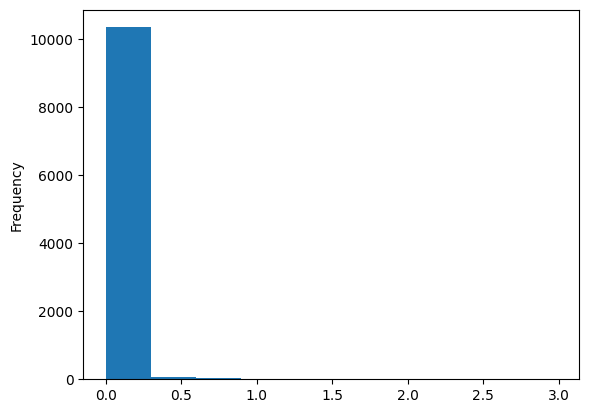

In [19]:
df_with_predictions.pred_diff.plot(kind='hist')

<ipython-input-20-ed032e55e181>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2) # required if we want to plot multiple figures from the same cell


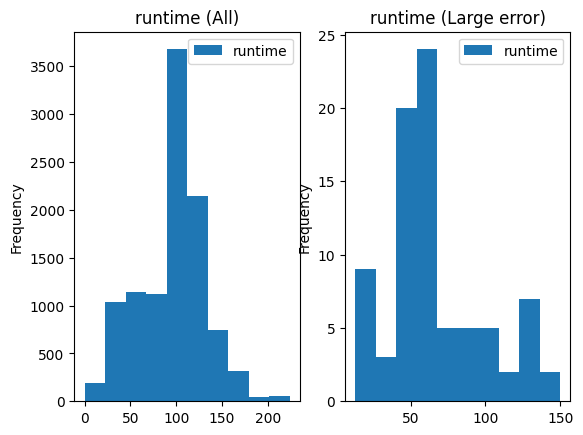

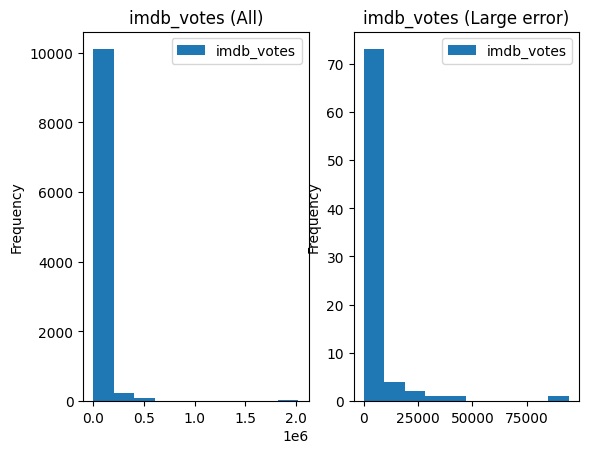

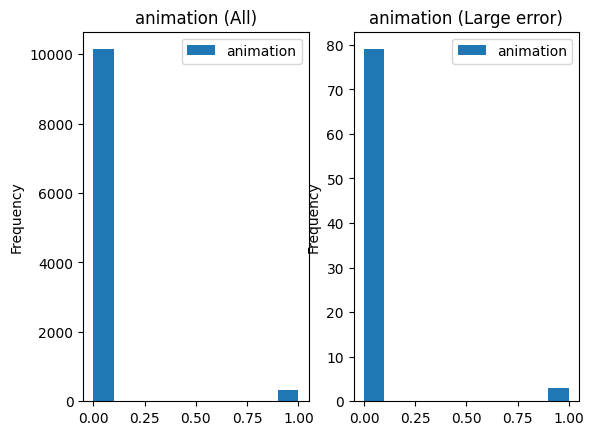

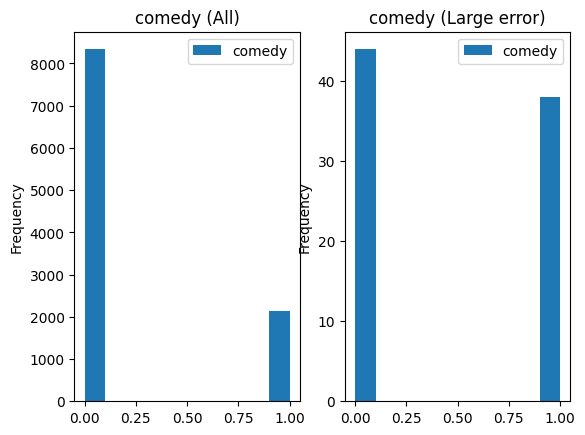

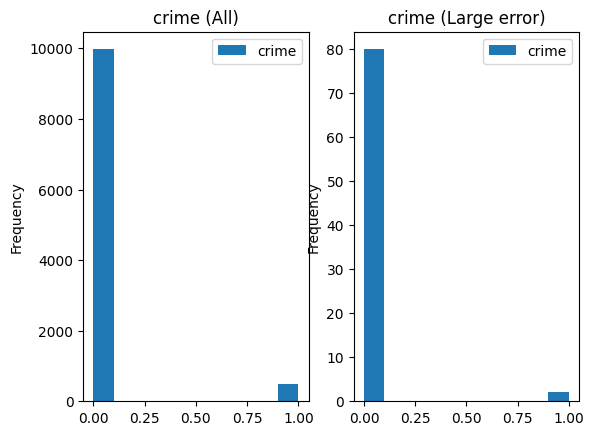

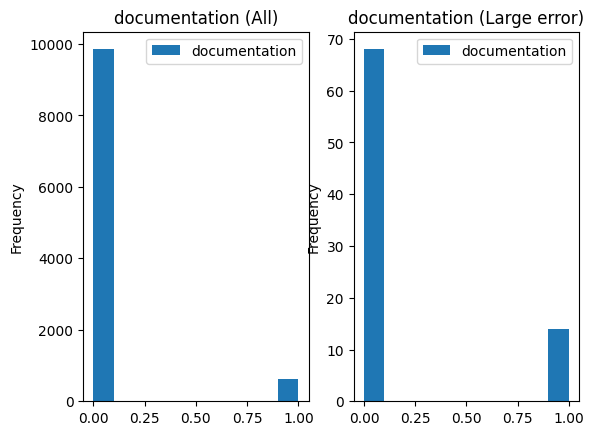

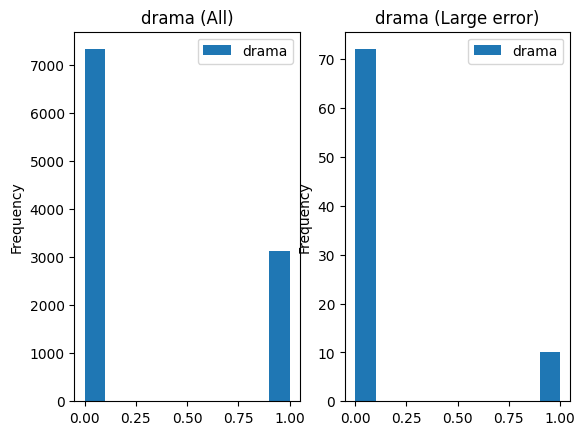

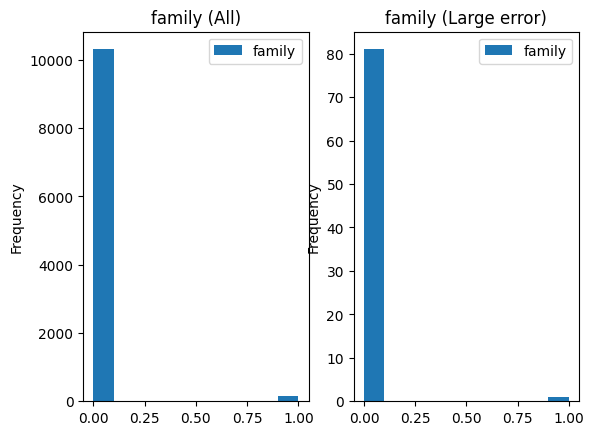

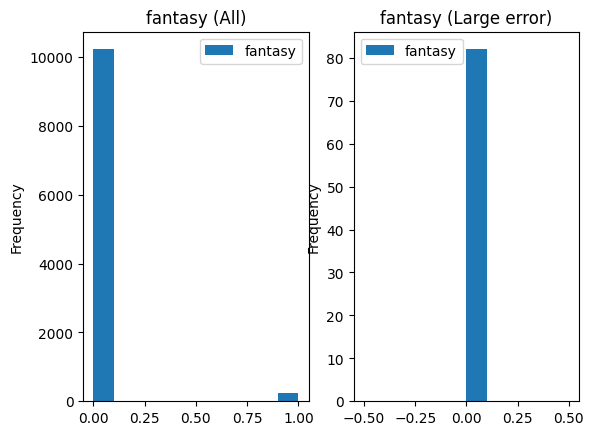

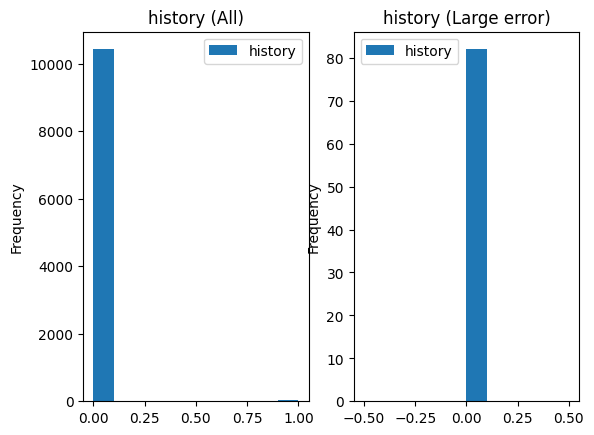

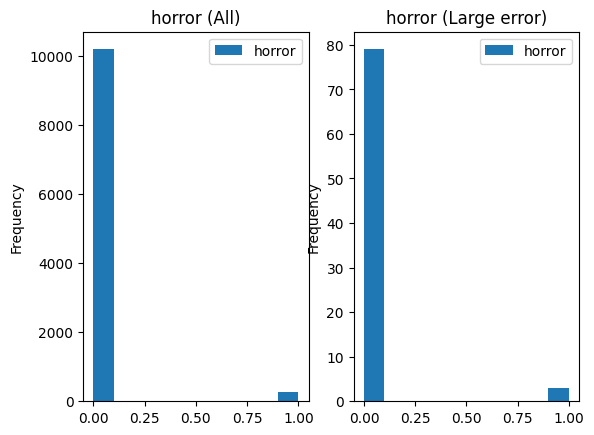

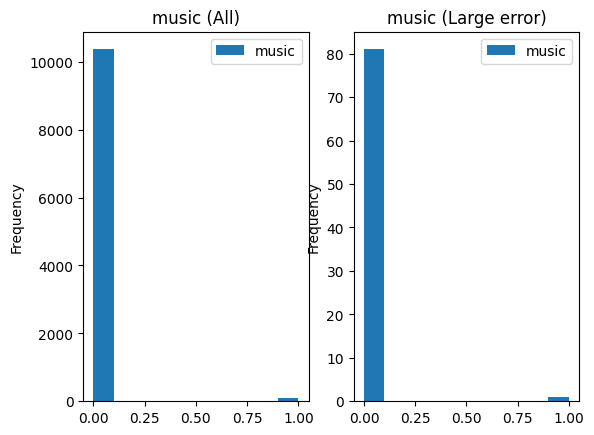

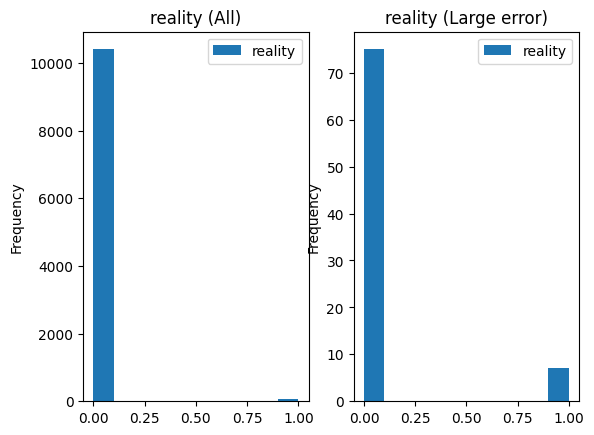

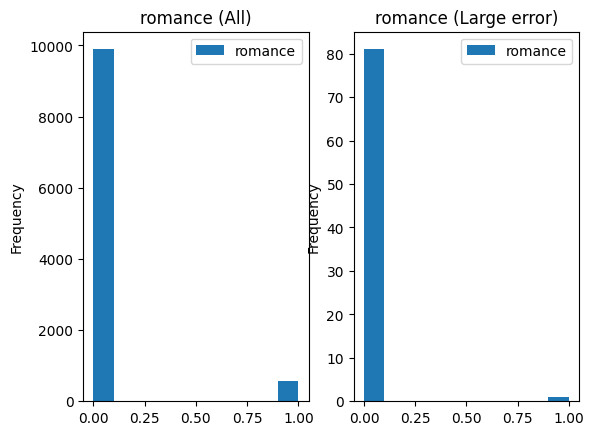

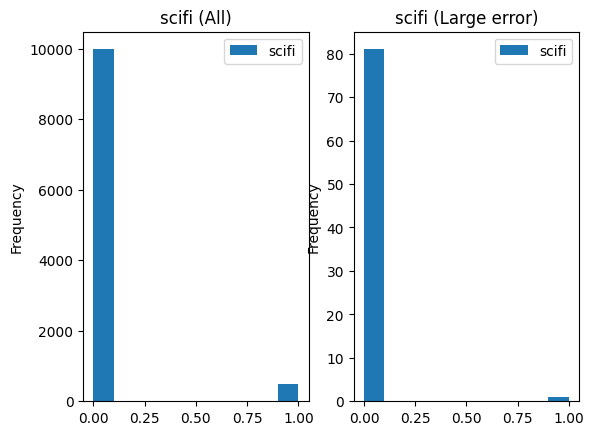

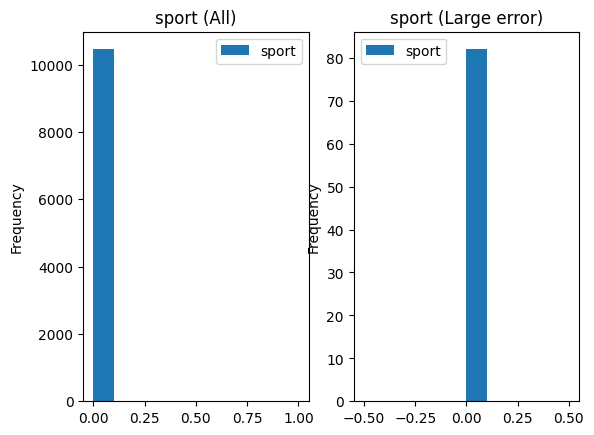

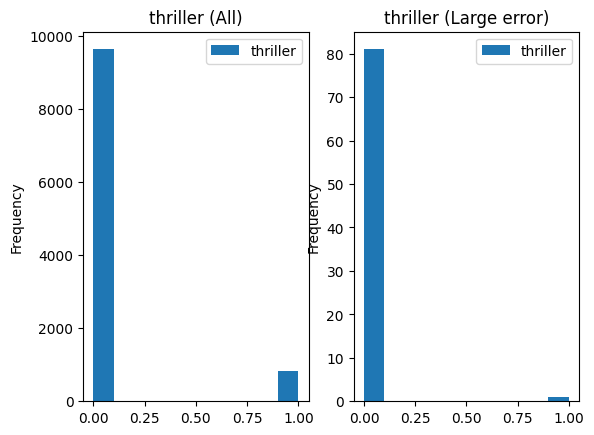

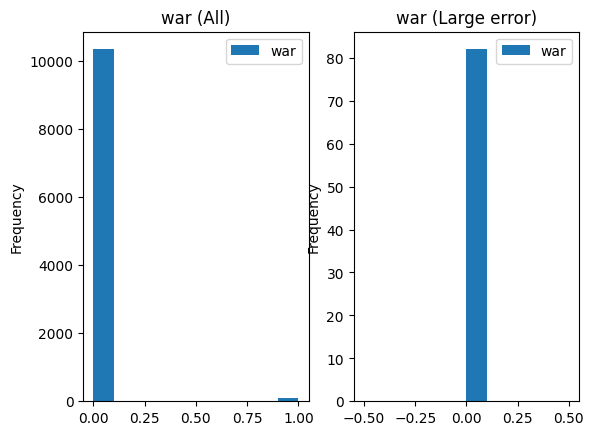

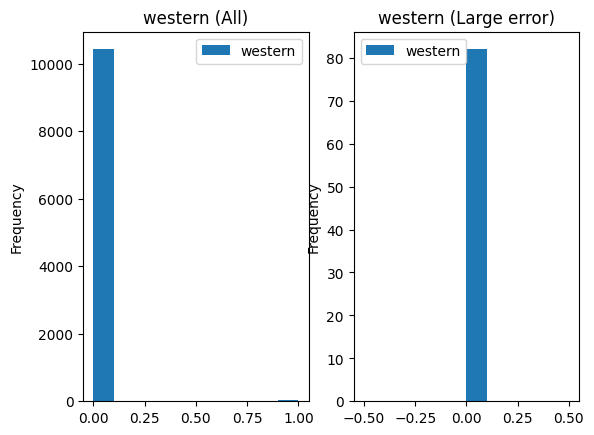

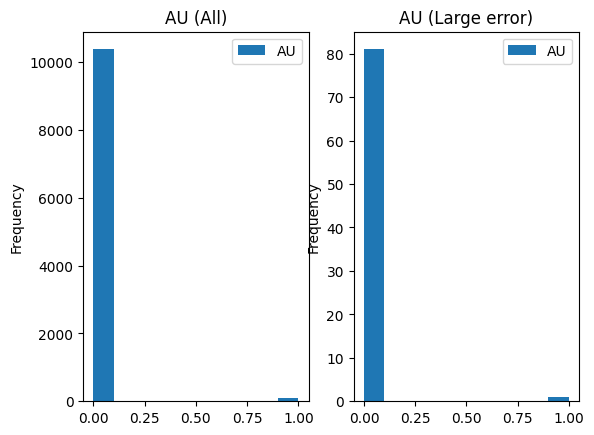

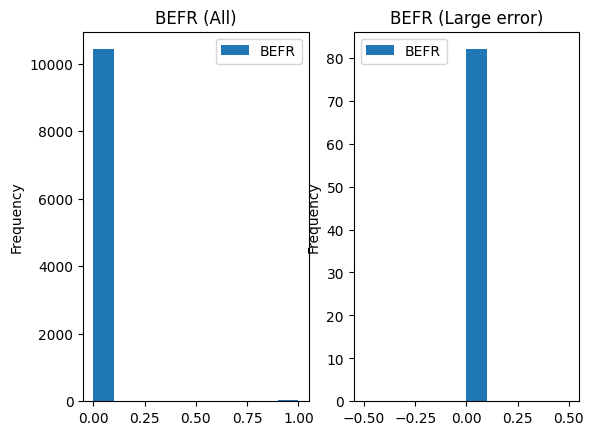

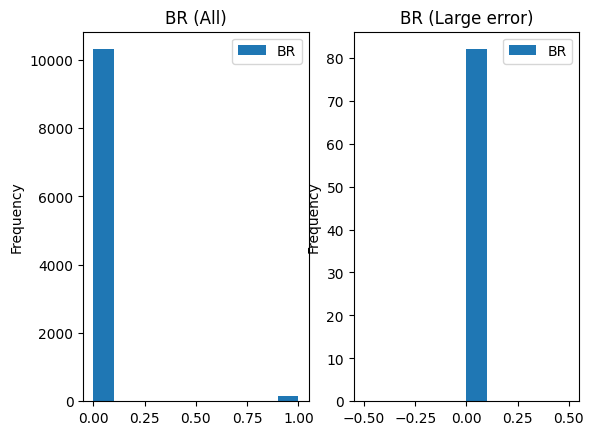

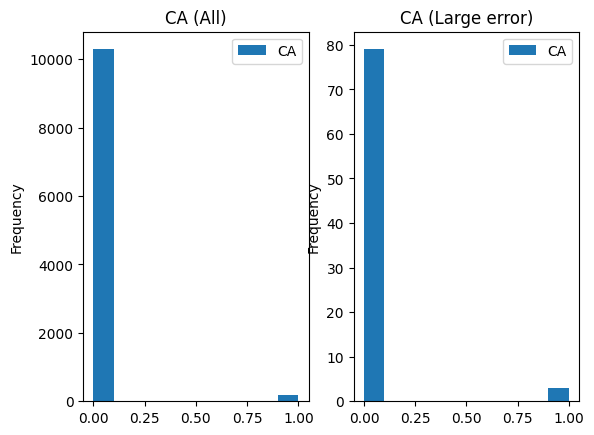

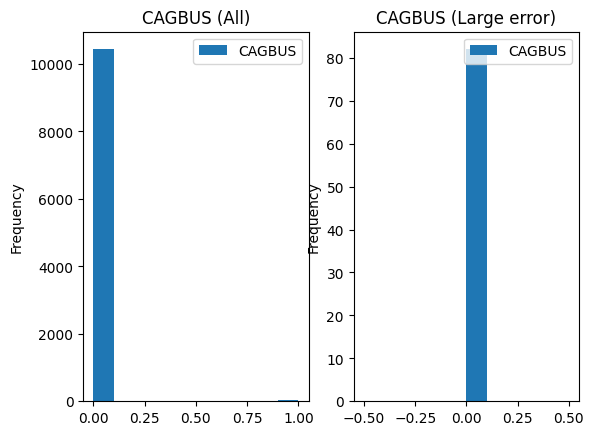

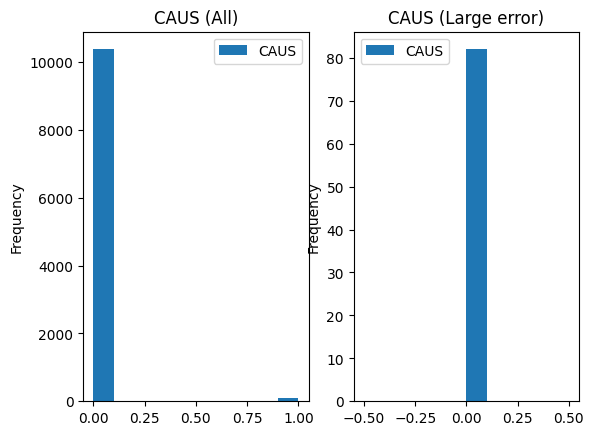

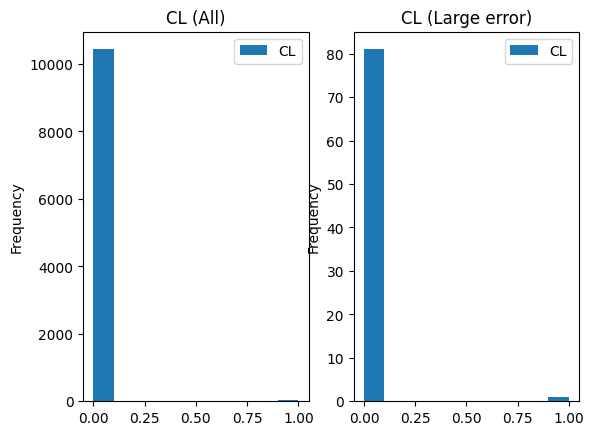

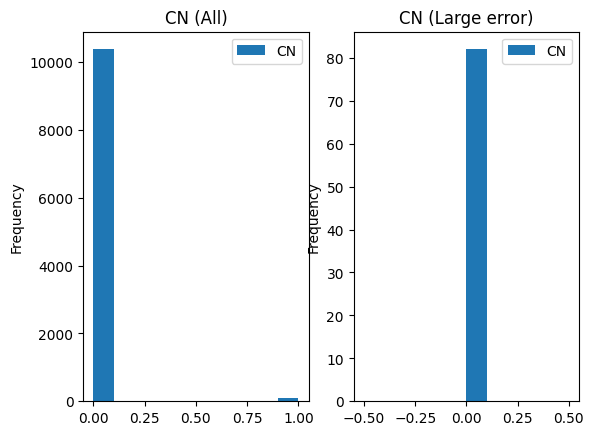

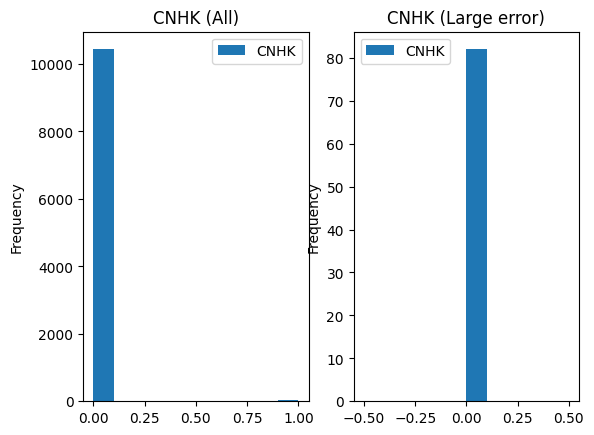

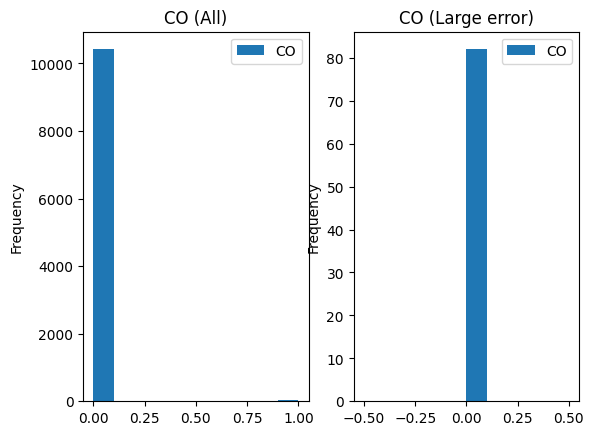

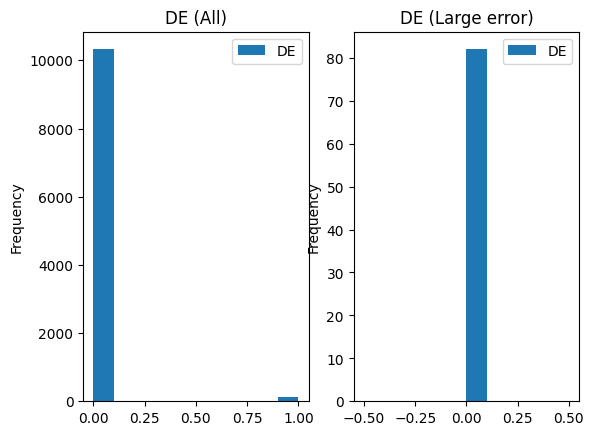

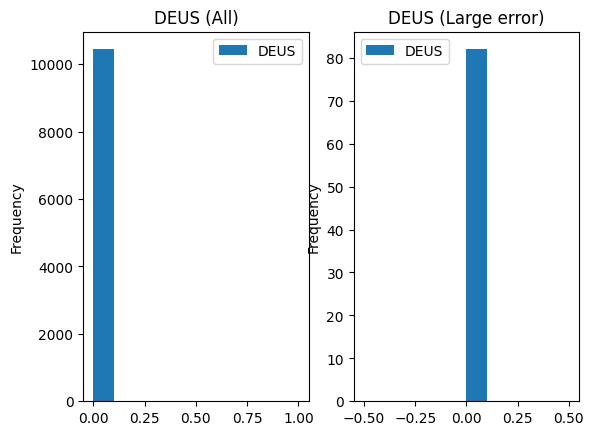

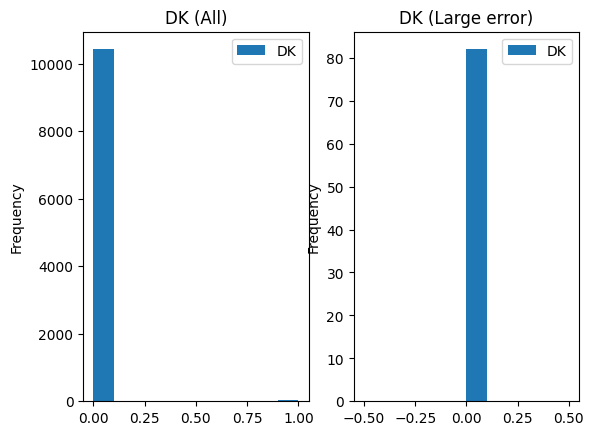

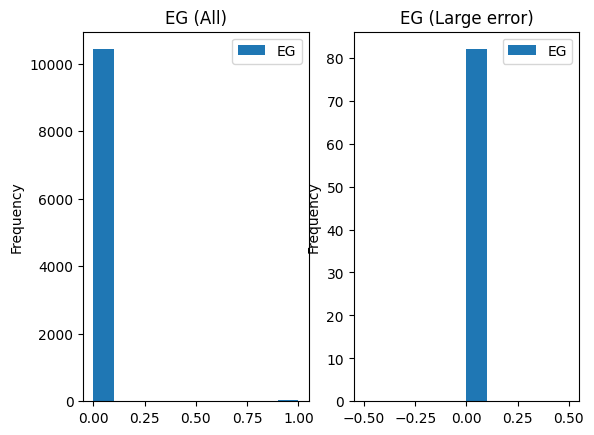

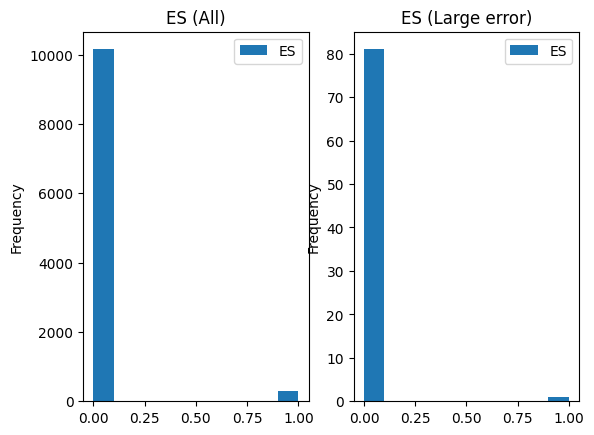

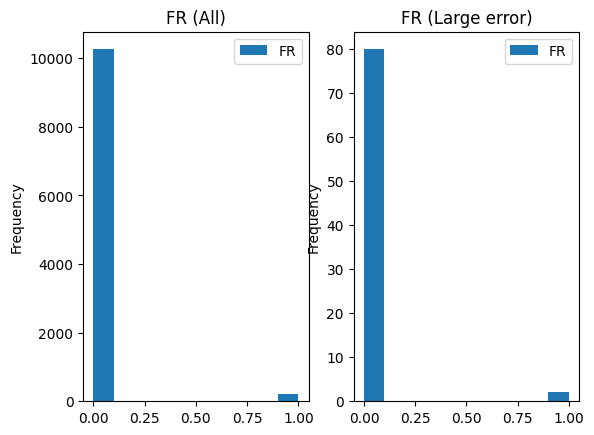

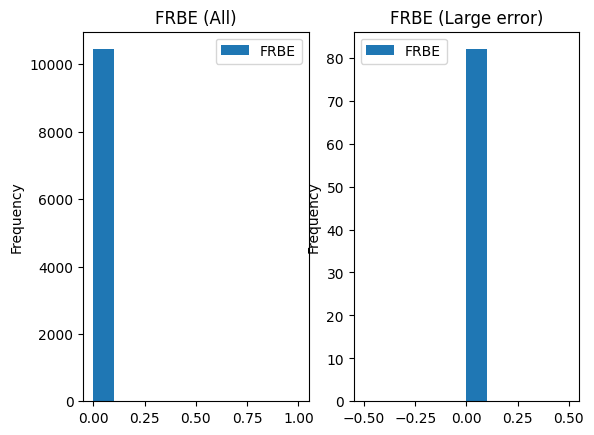

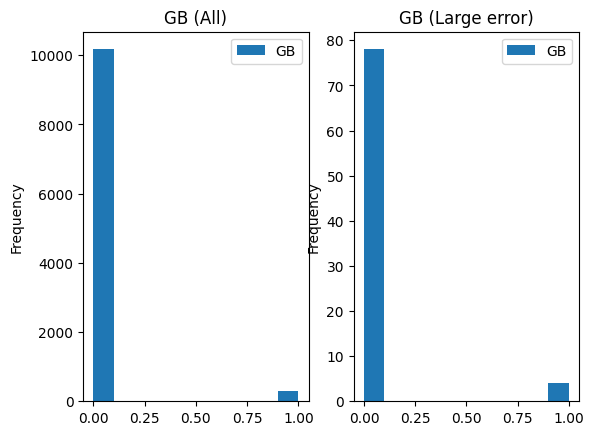

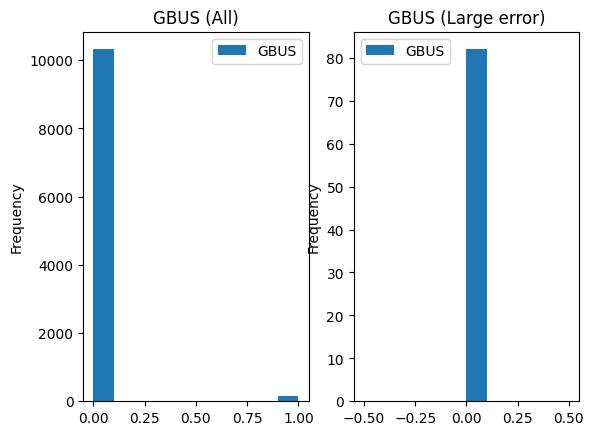

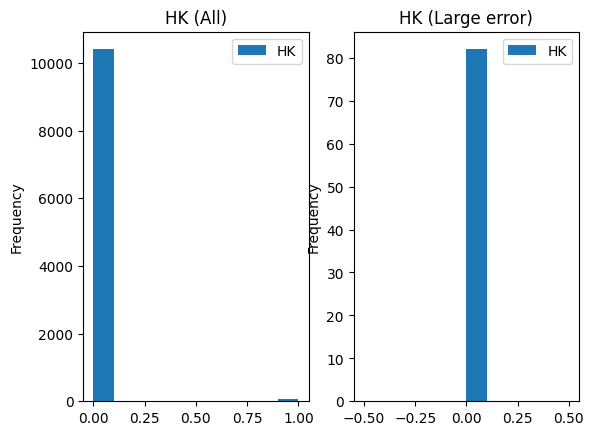

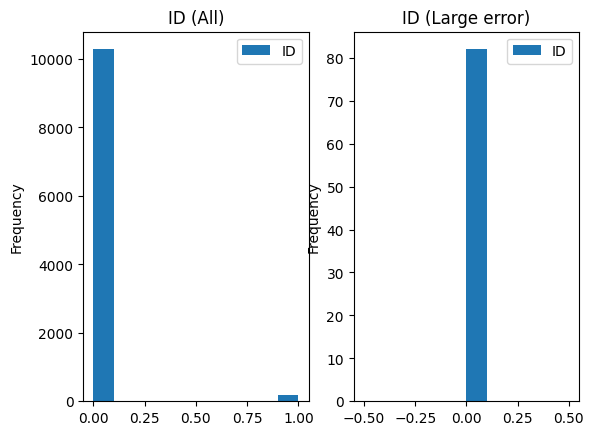

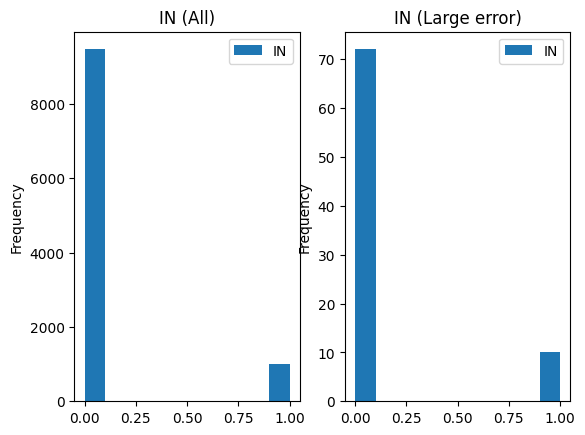

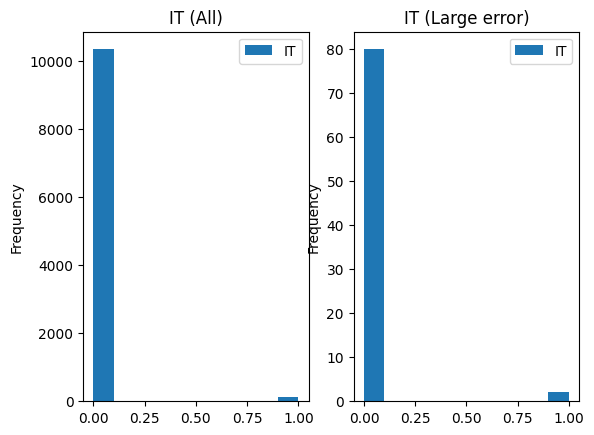

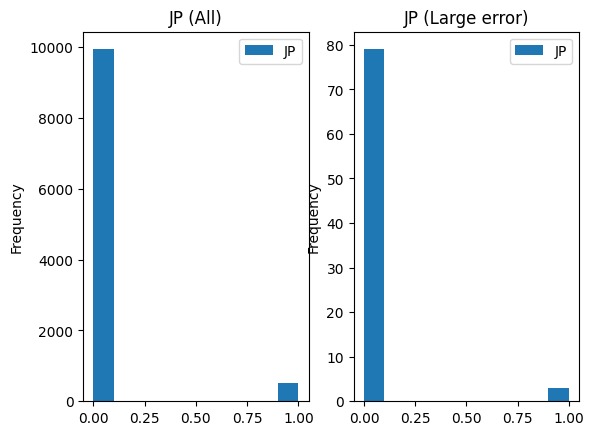

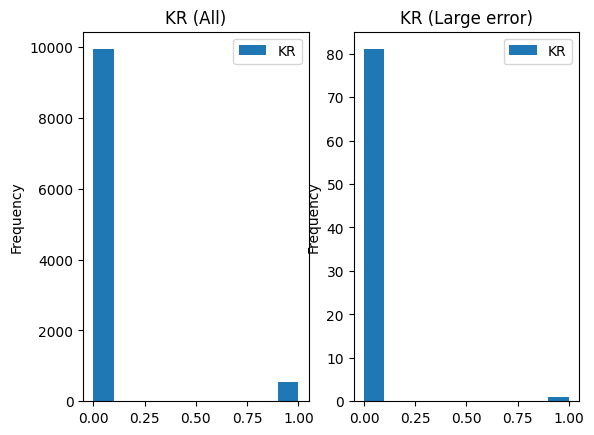

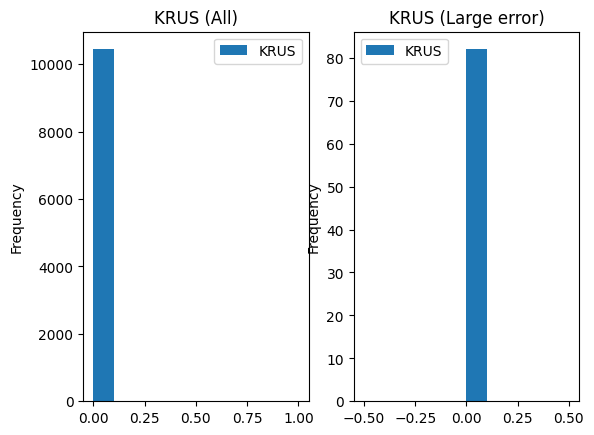

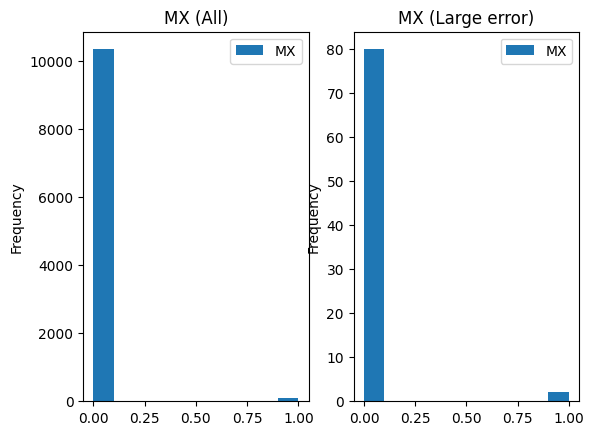

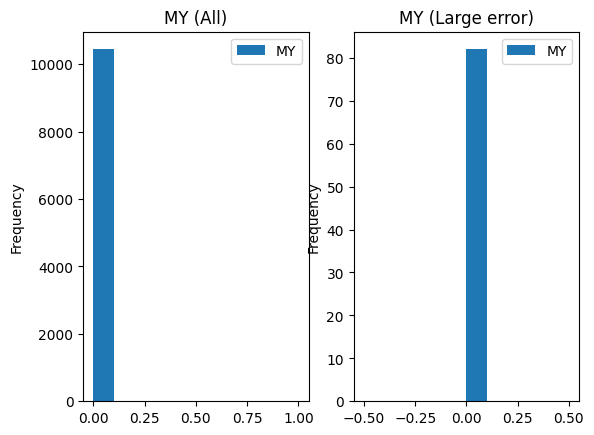

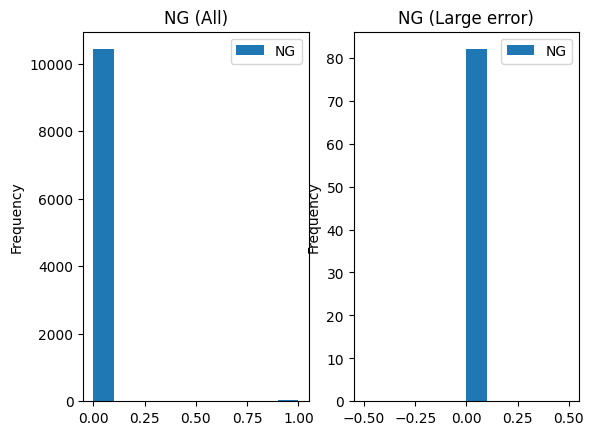

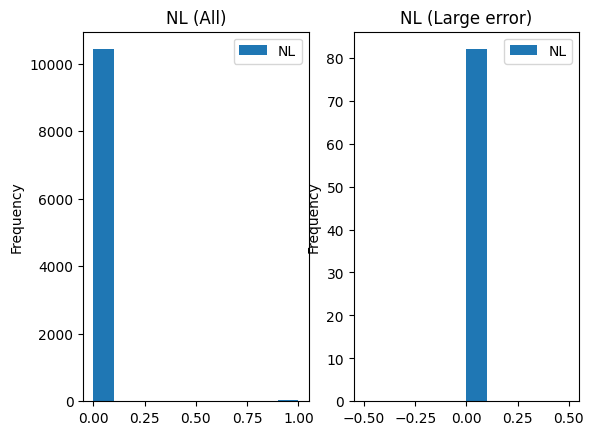

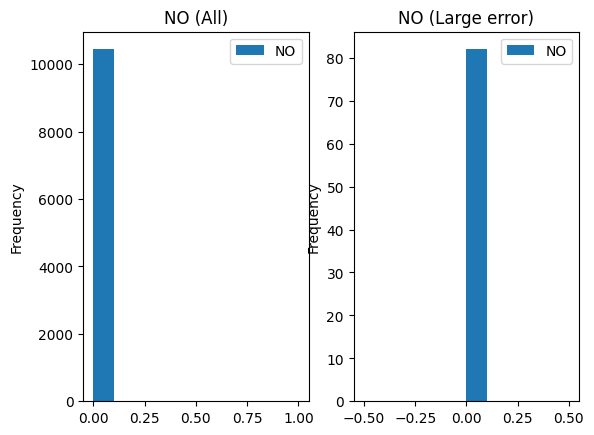

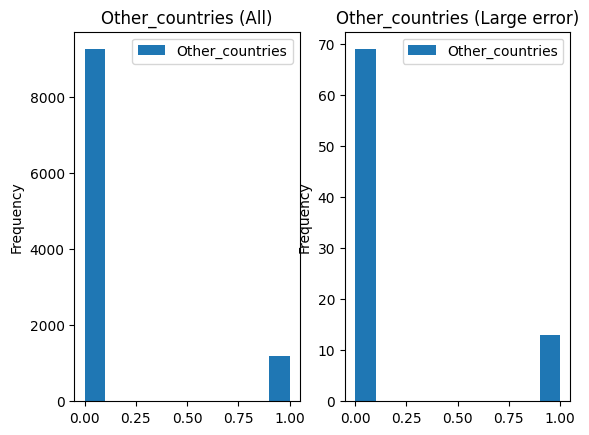

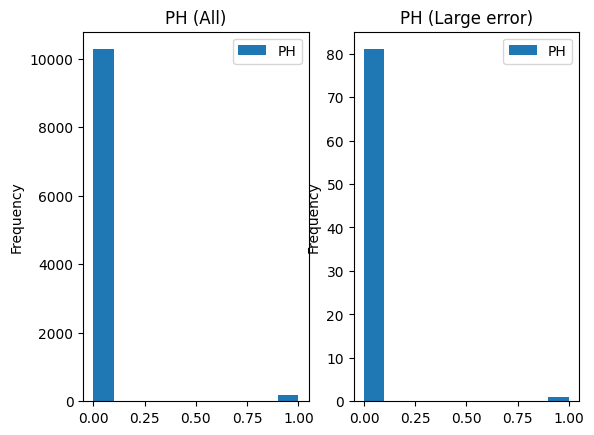

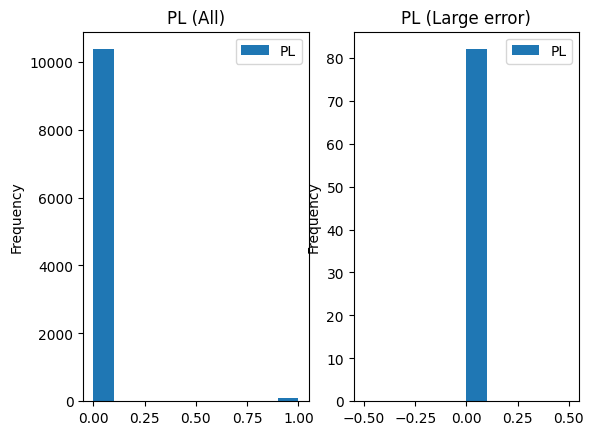

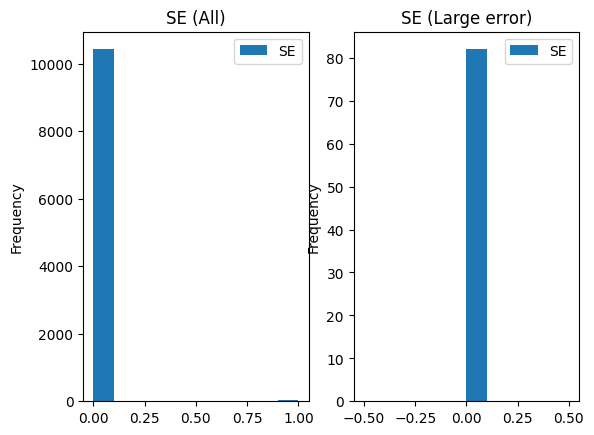

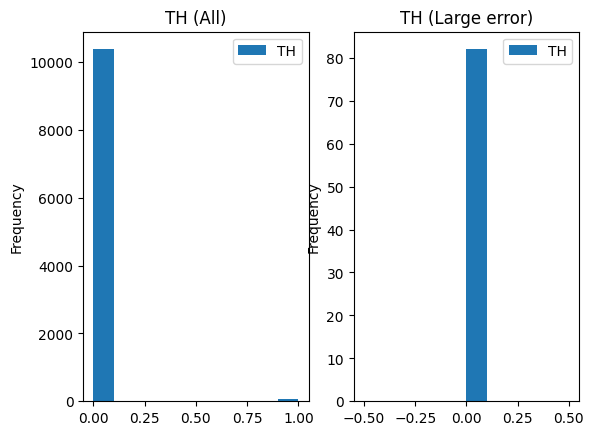

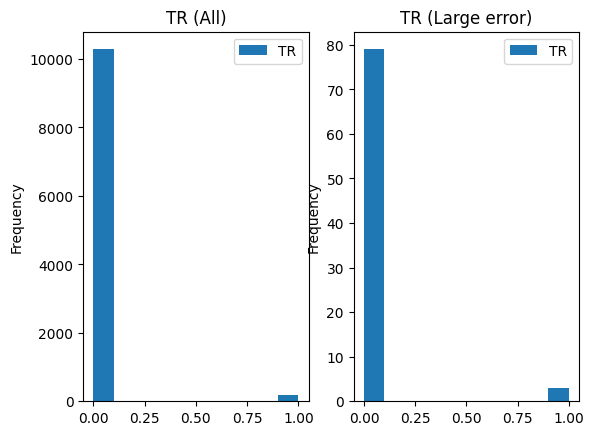

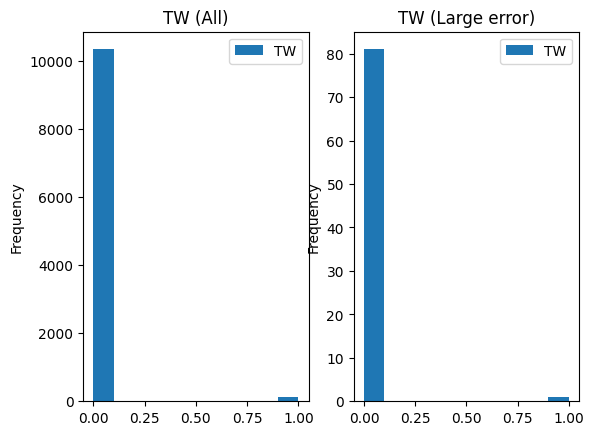

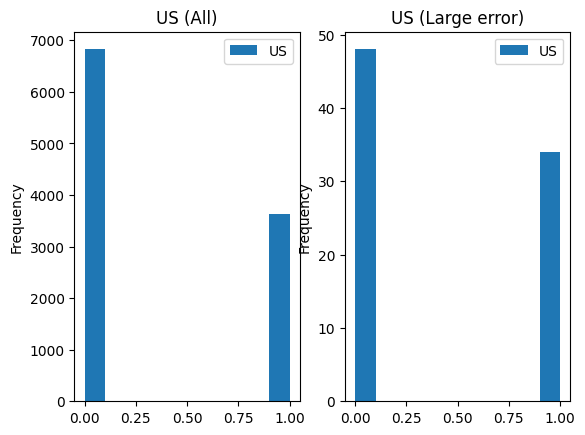

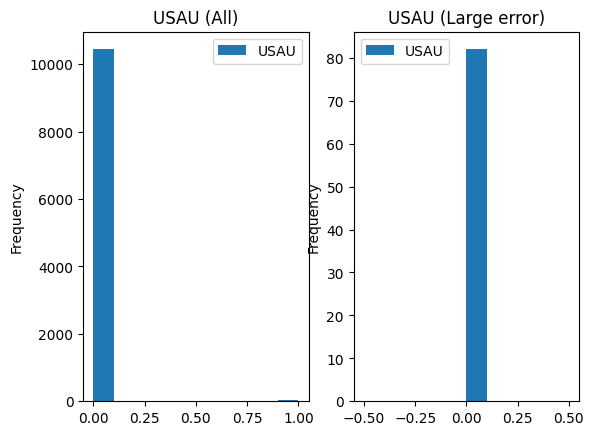

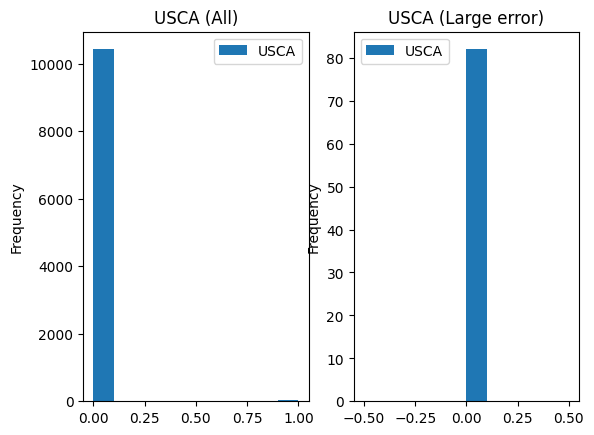

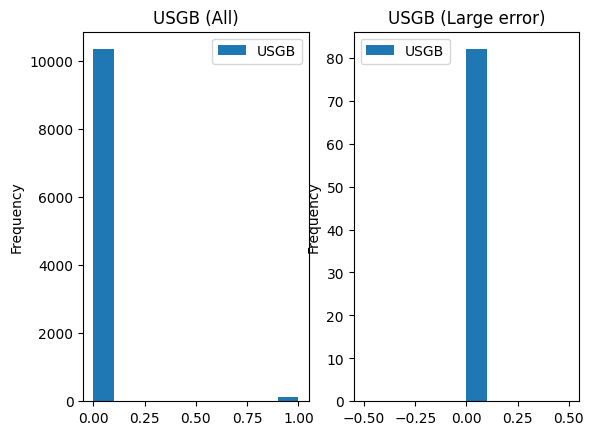

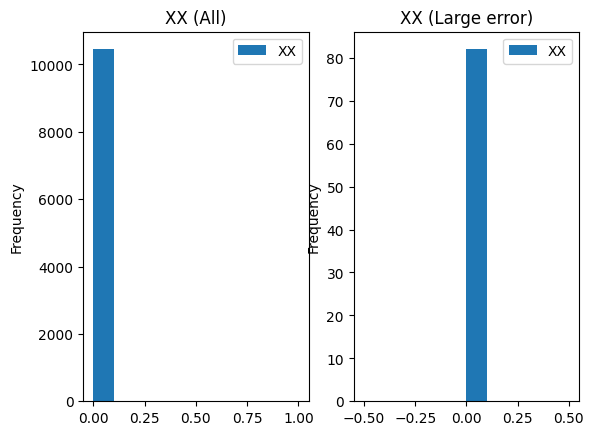

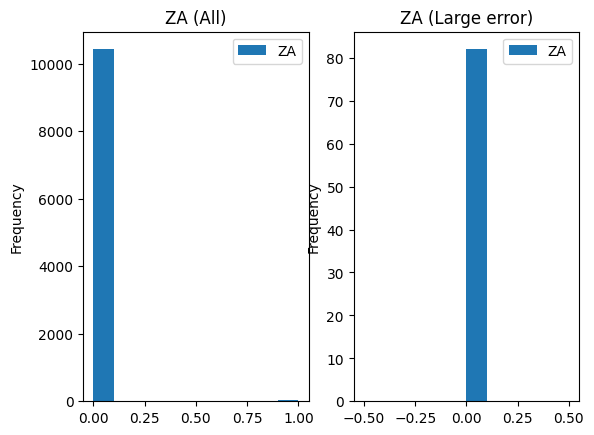

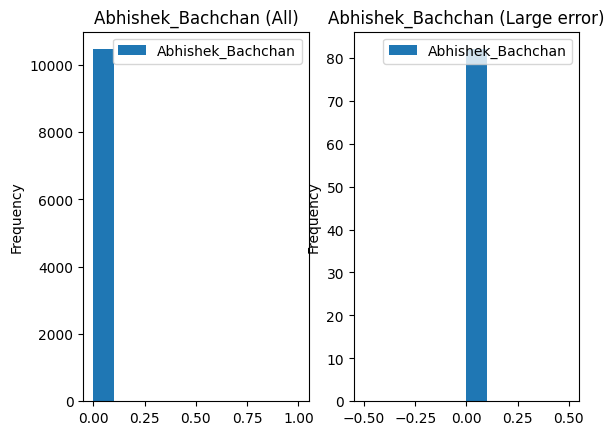

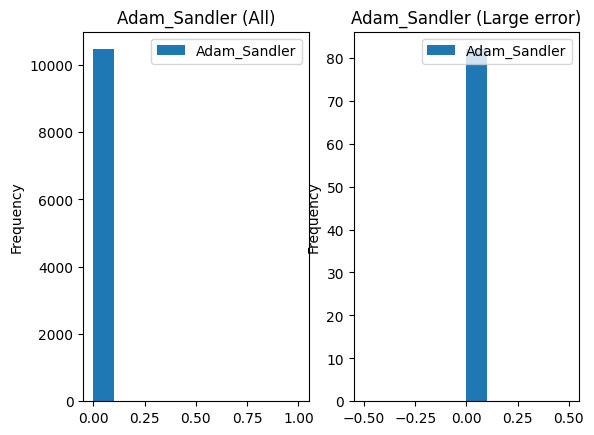

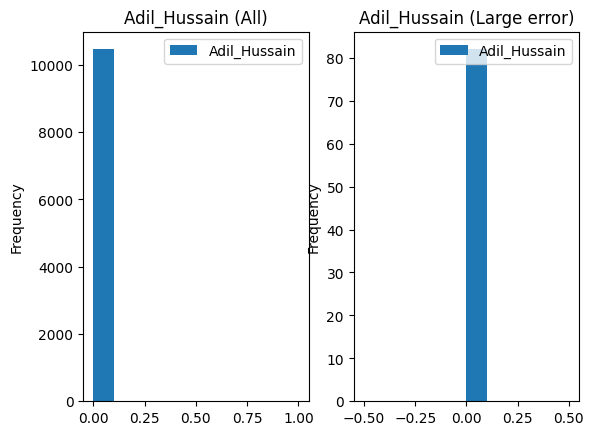

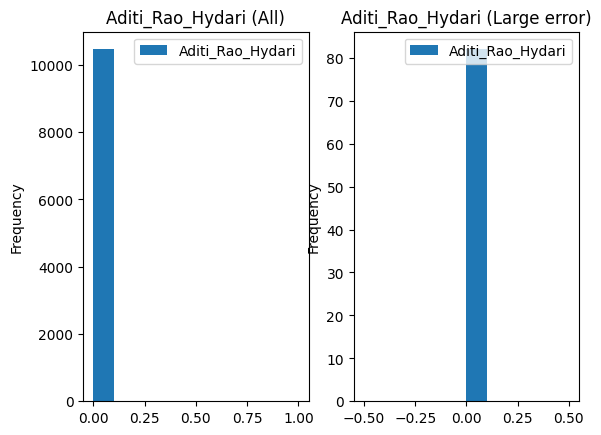

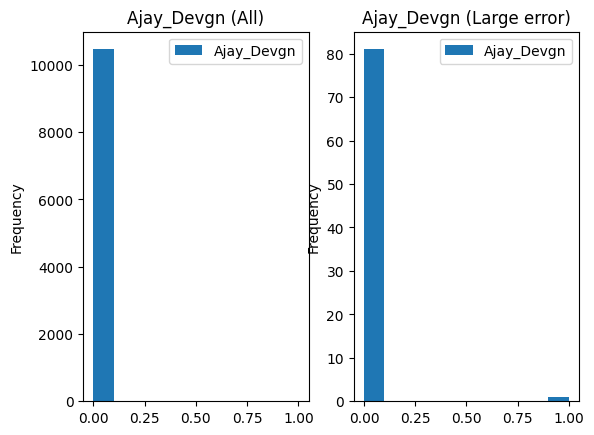

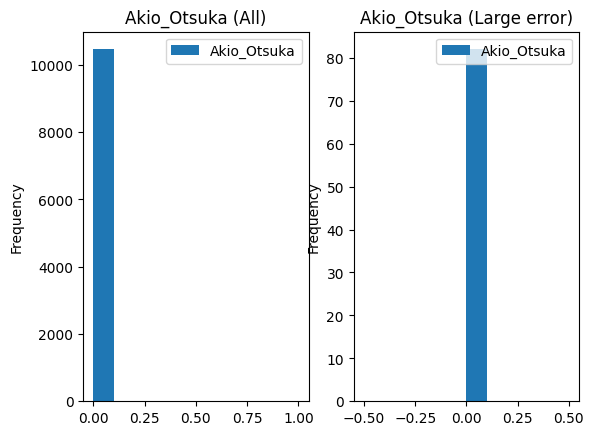

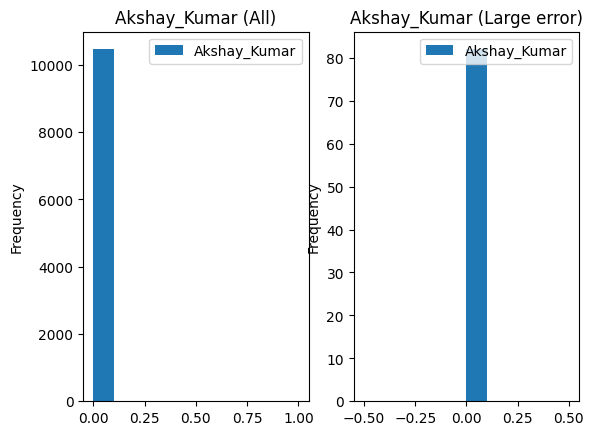

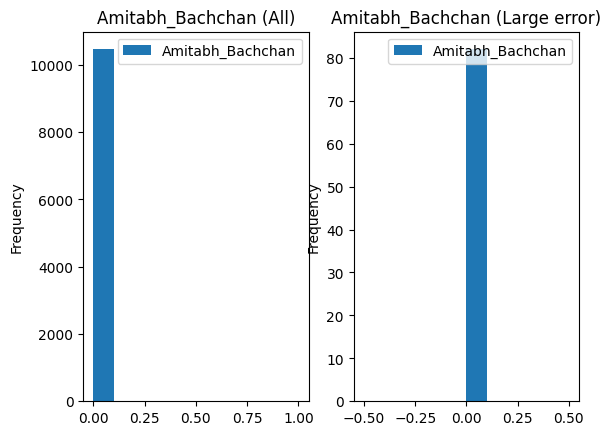

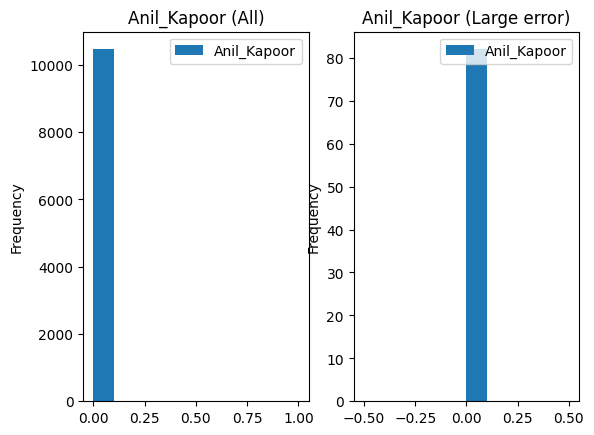

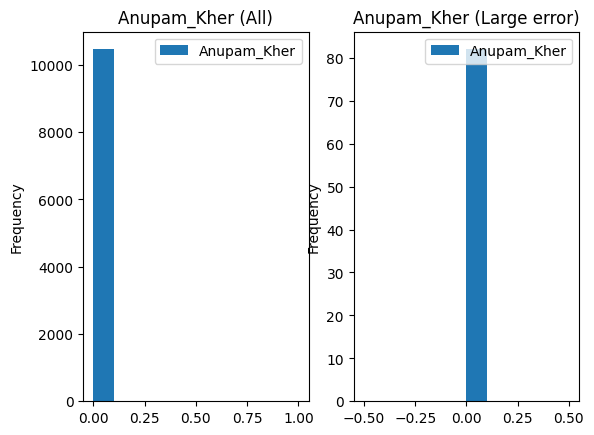

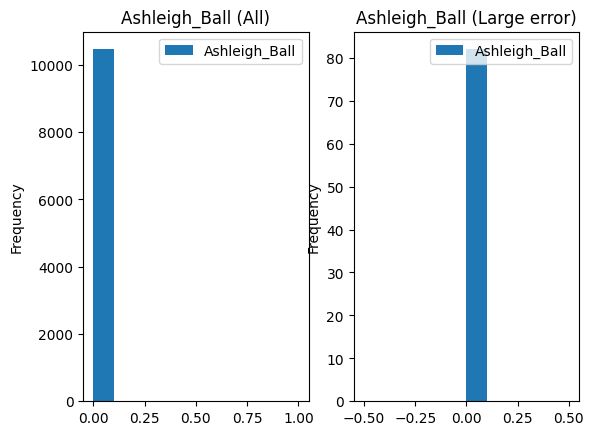

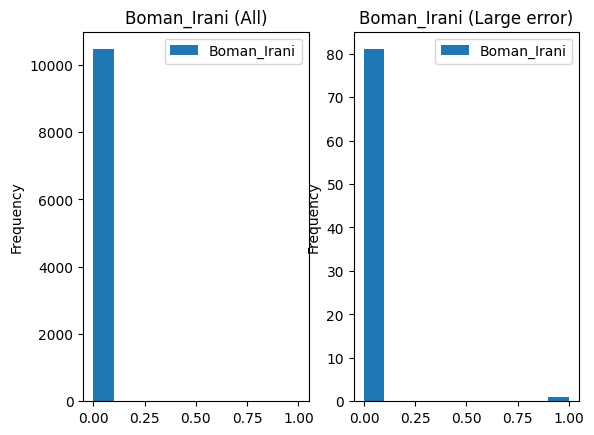

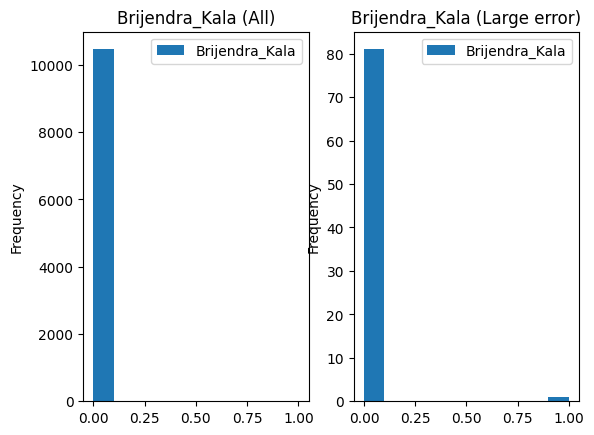

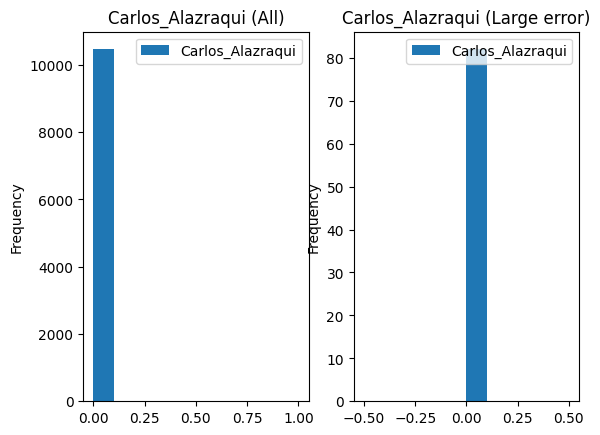

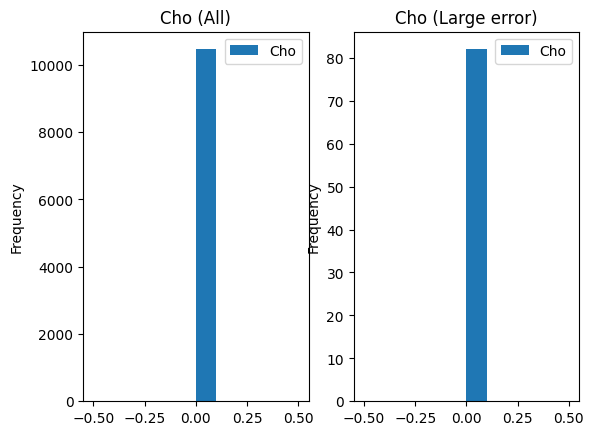

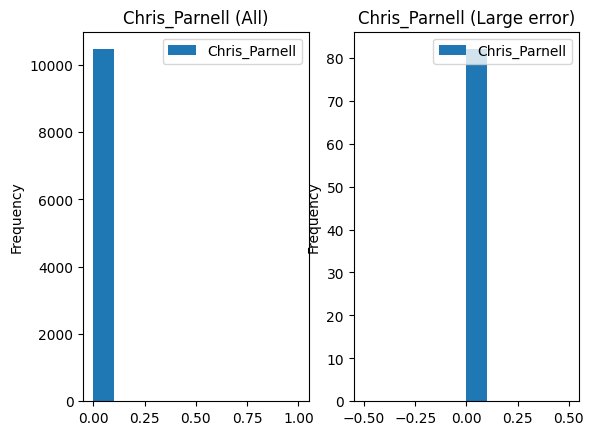

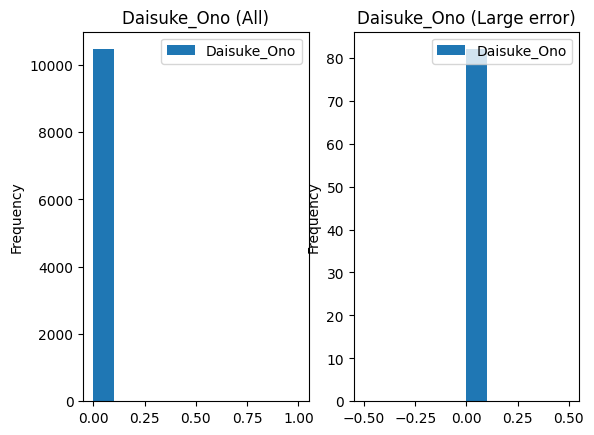

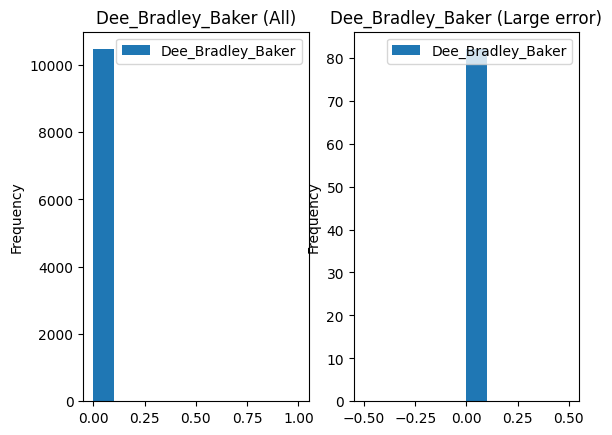

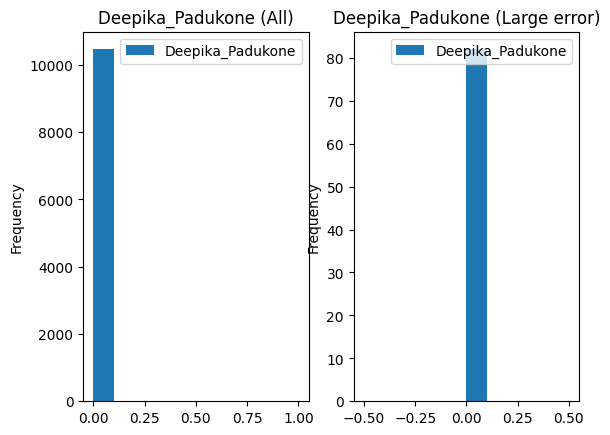

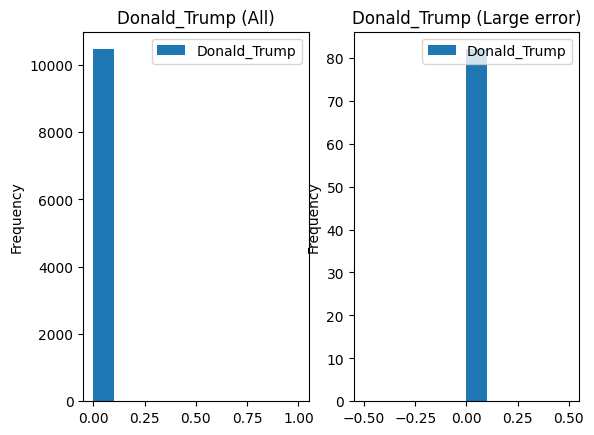

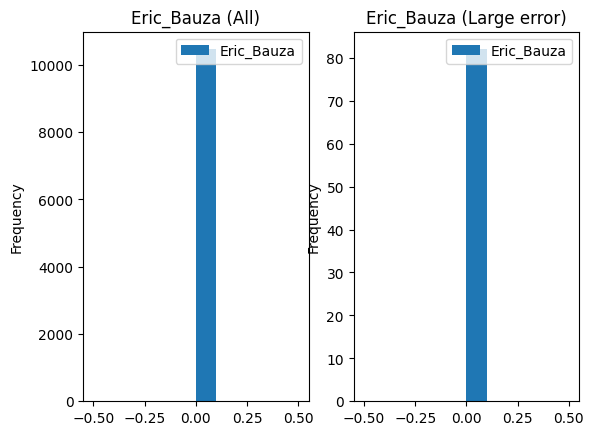

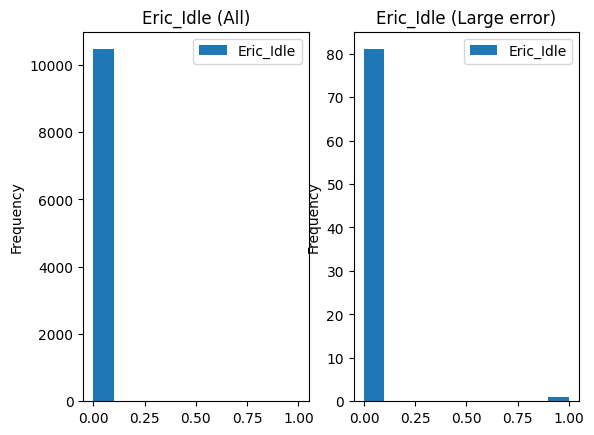

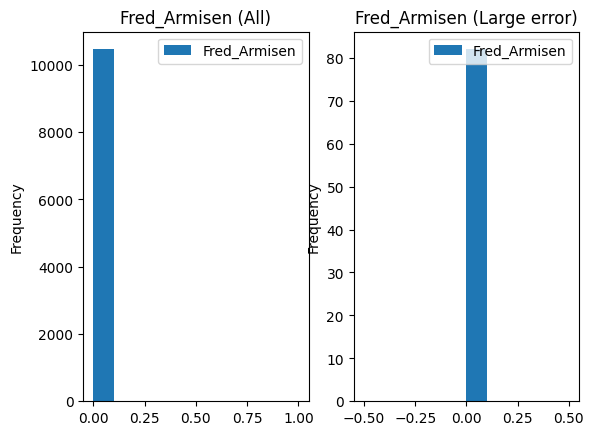

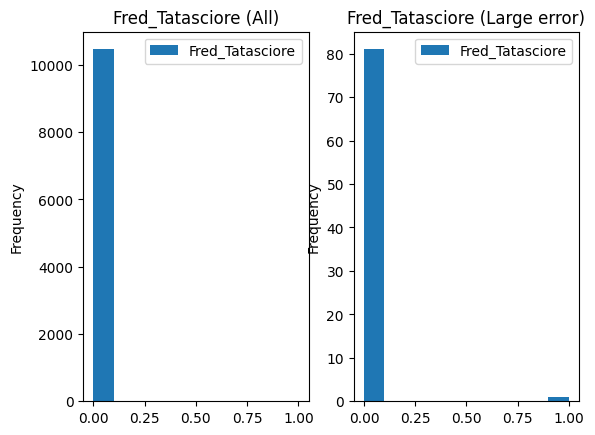

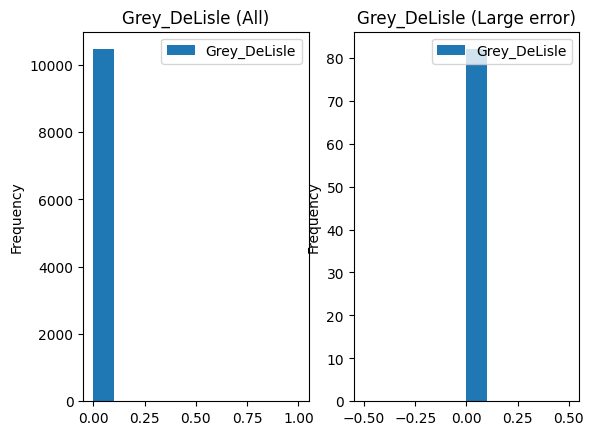

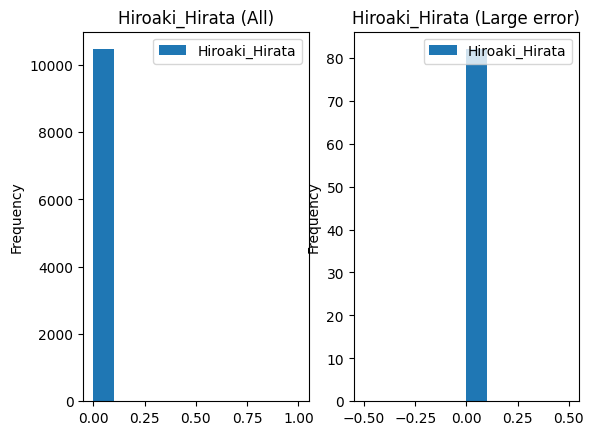

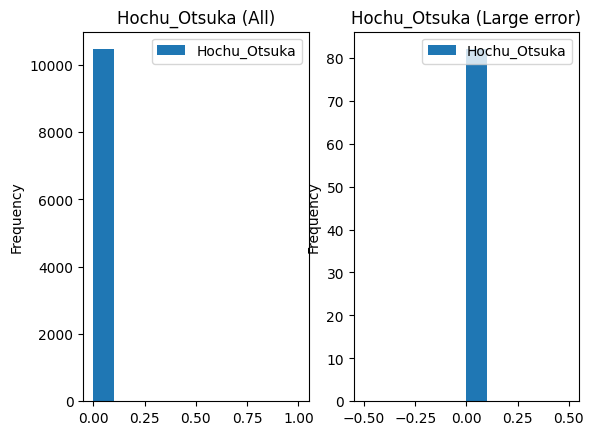

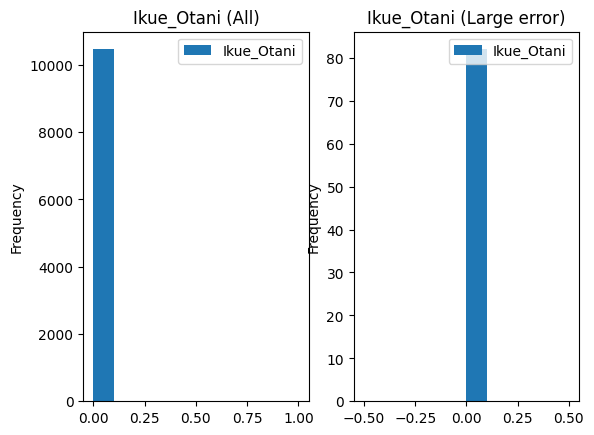

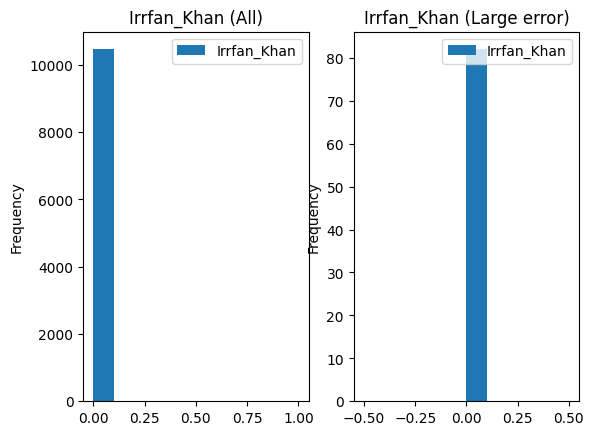

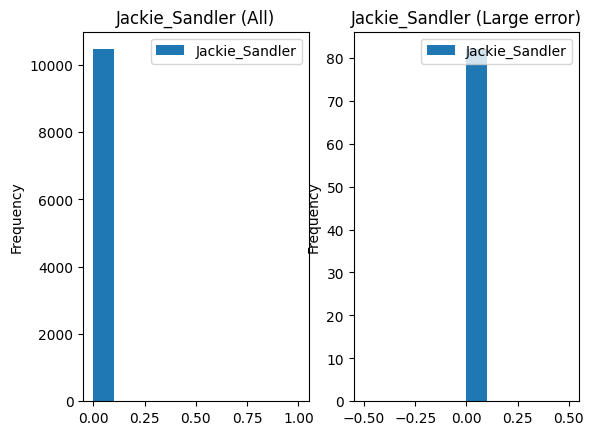

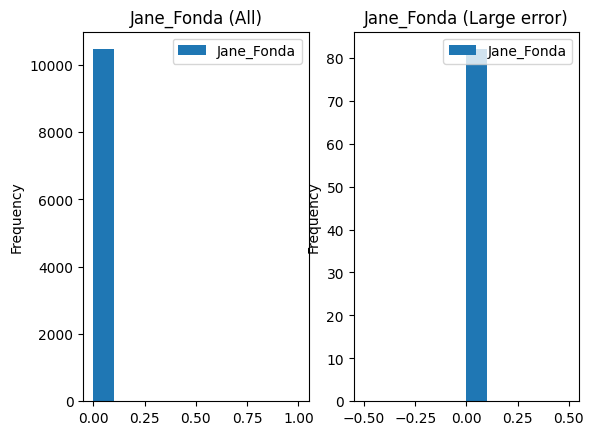

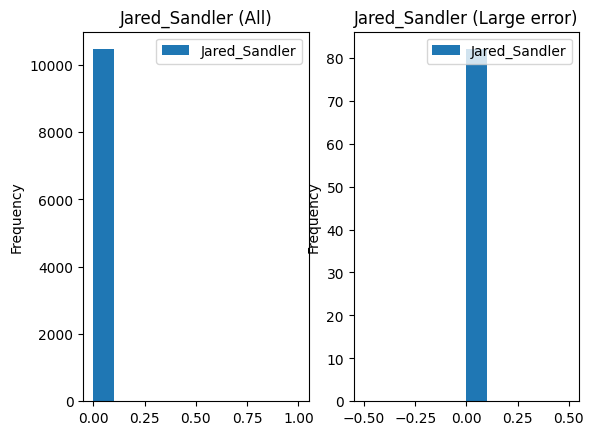

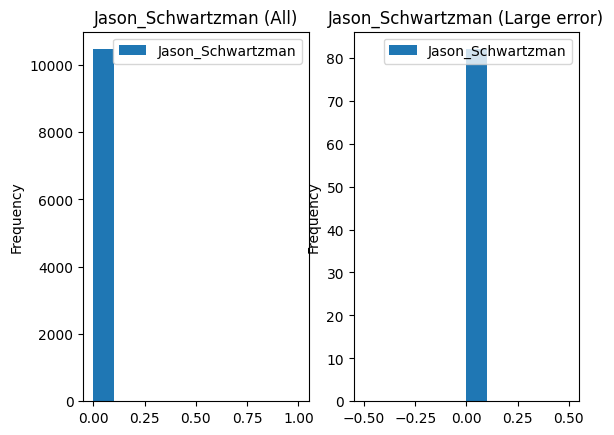

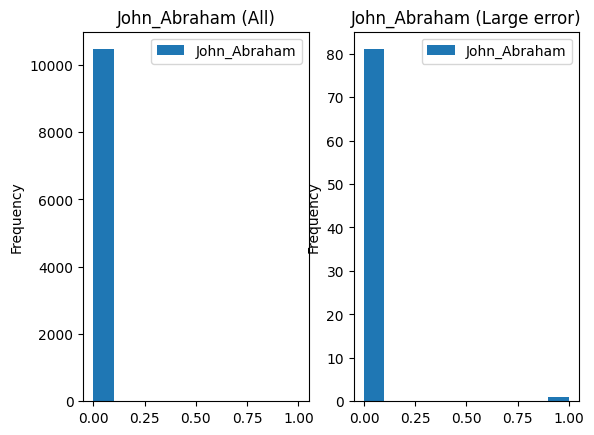

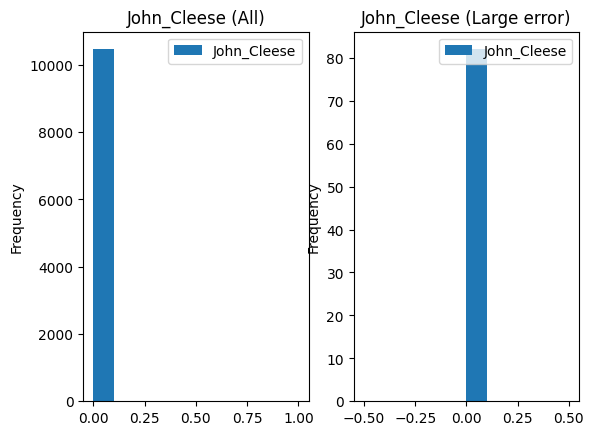

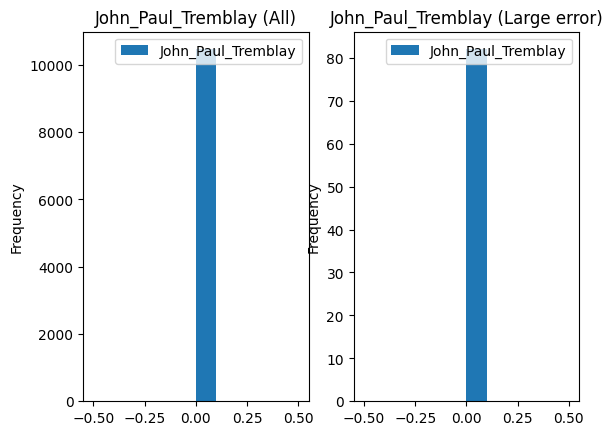

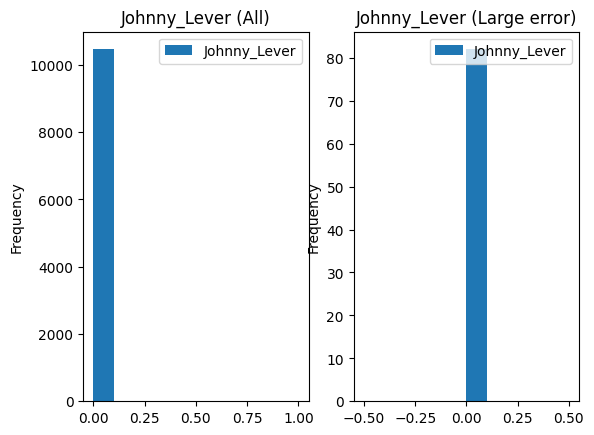

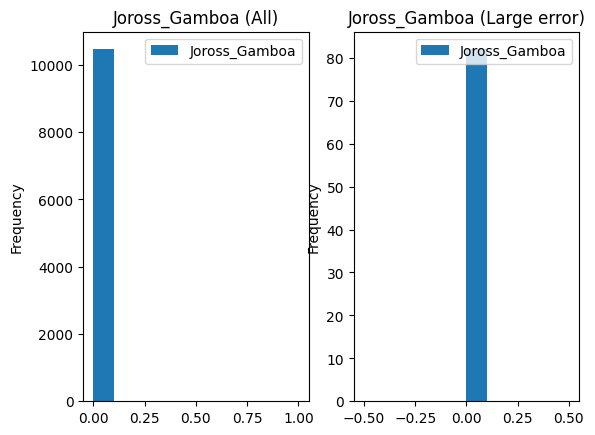

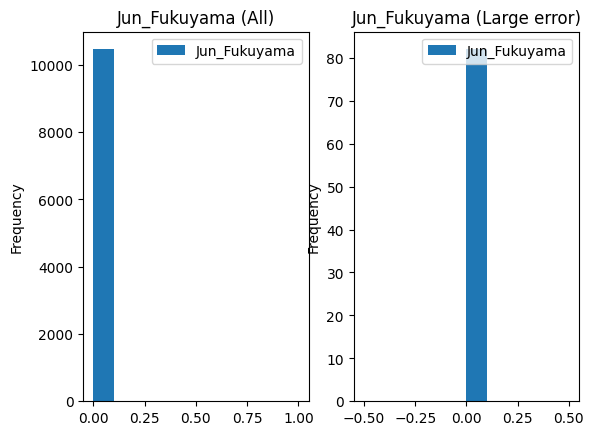

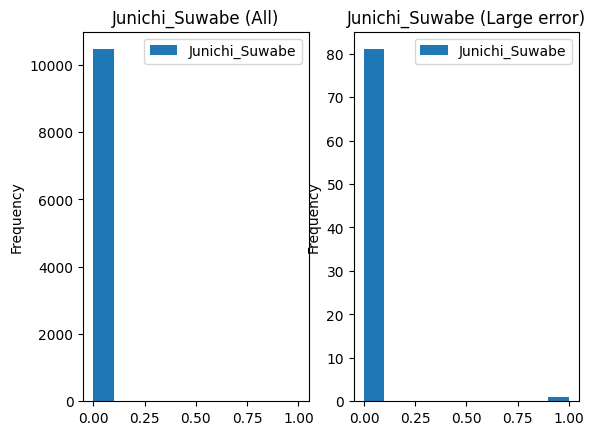

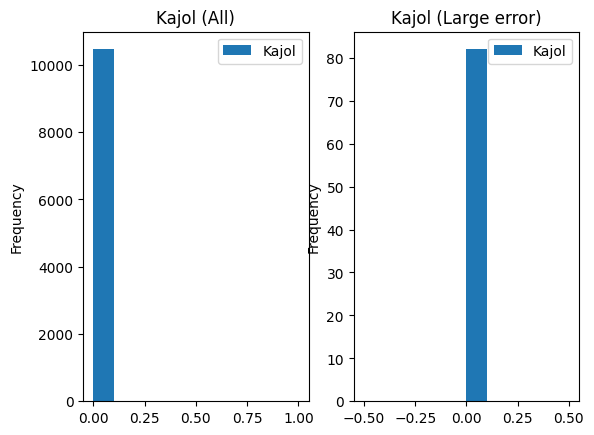

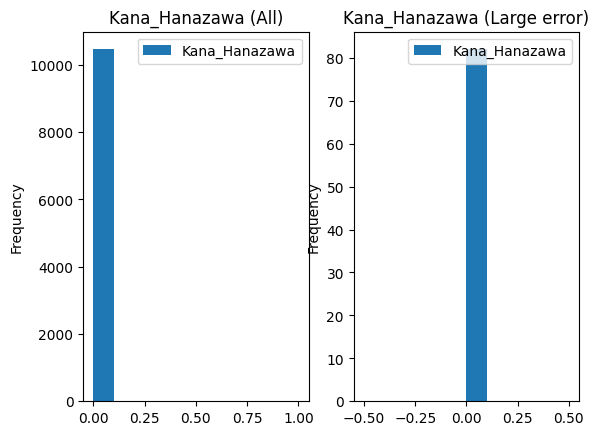

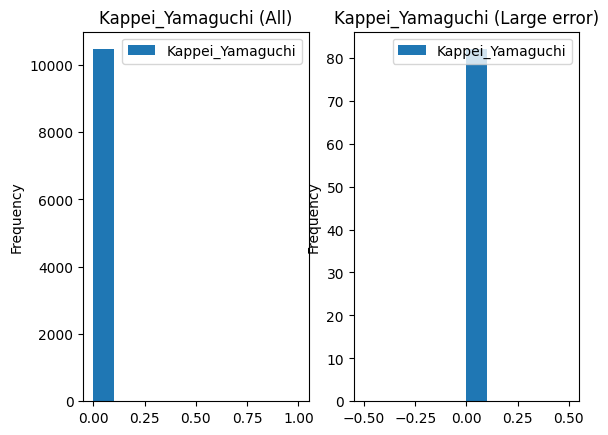

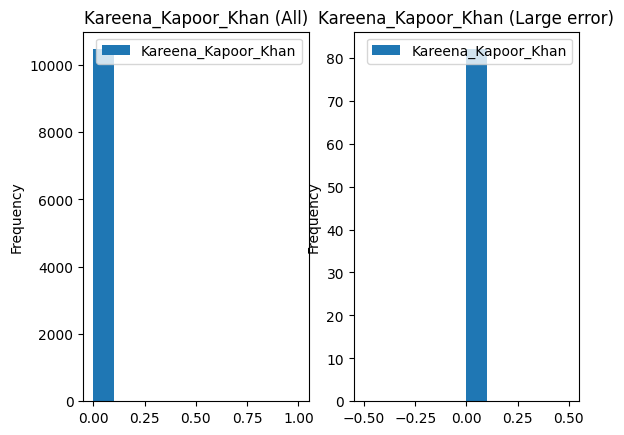

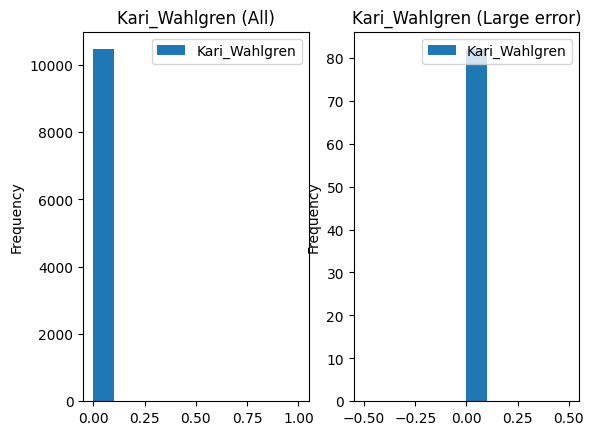

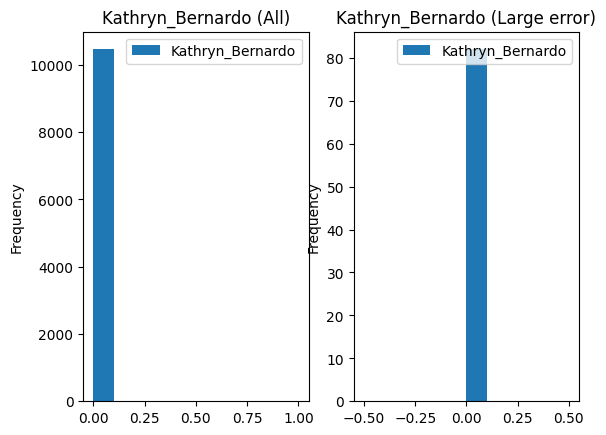

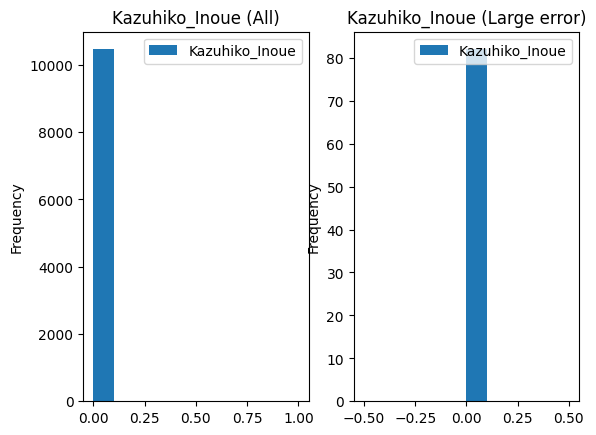

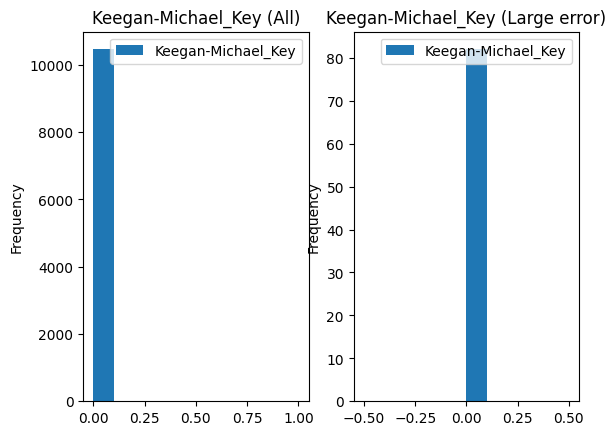

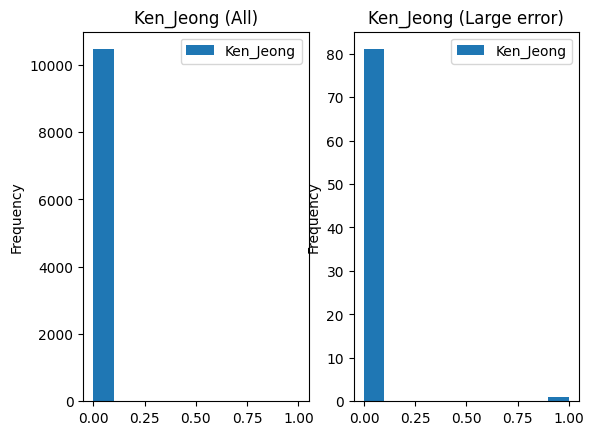

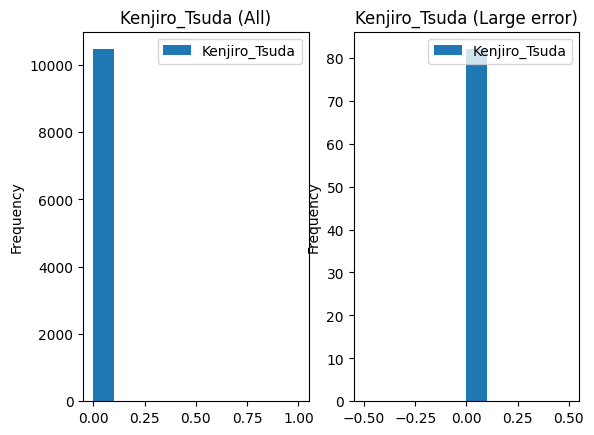

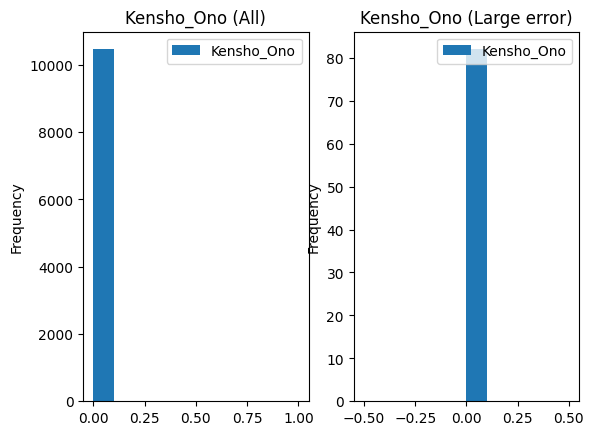

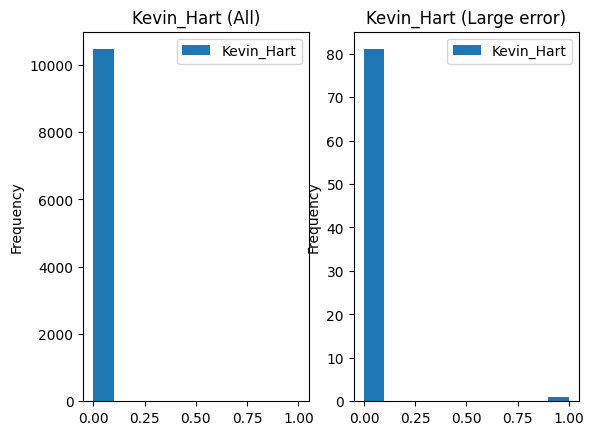

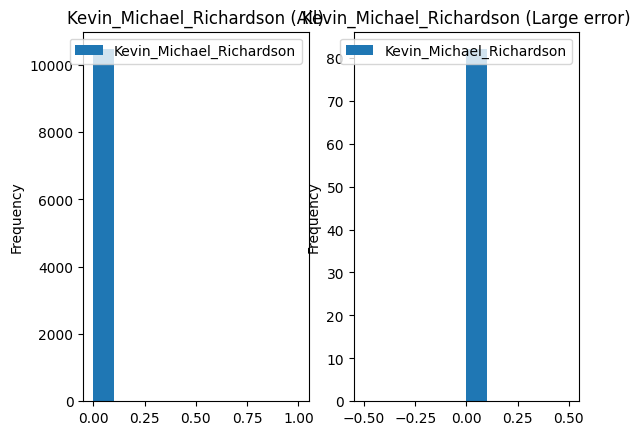

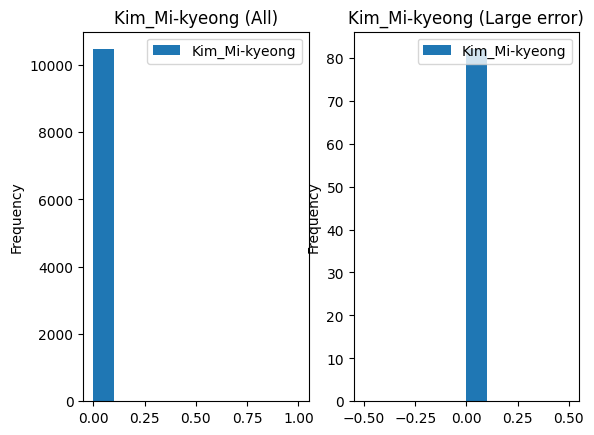

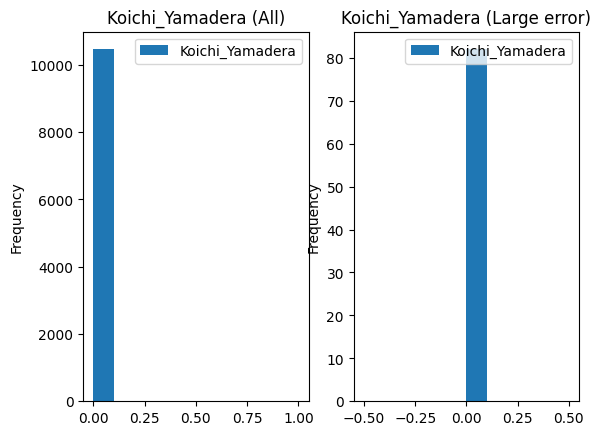

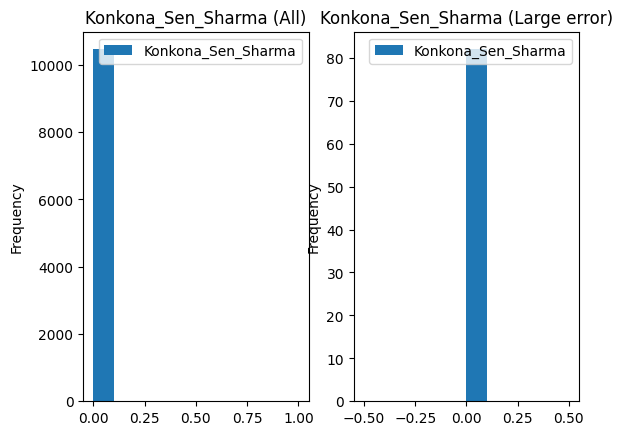

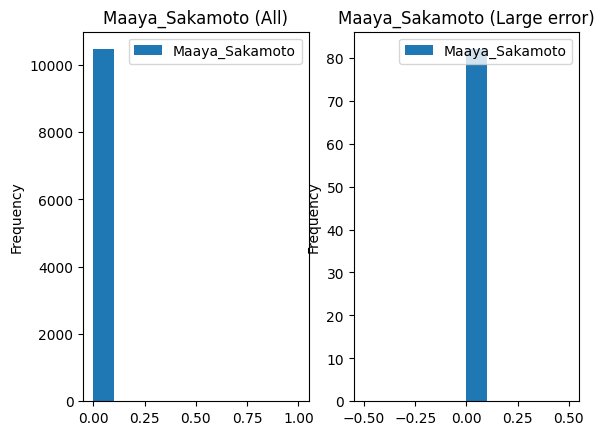

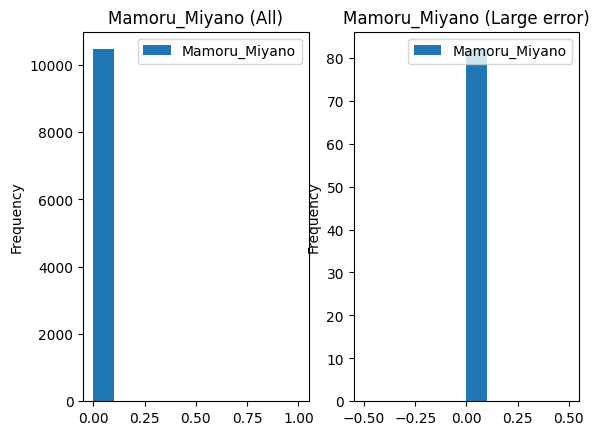

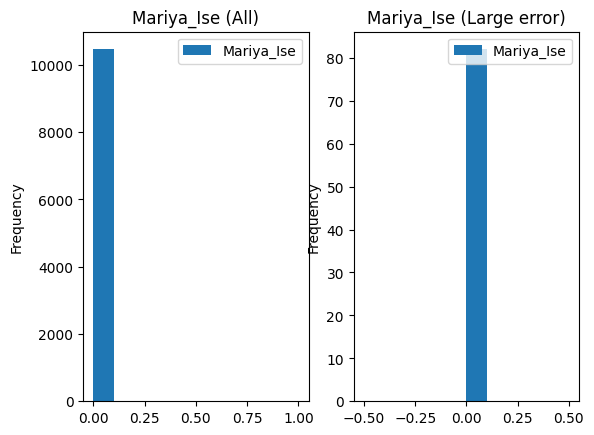

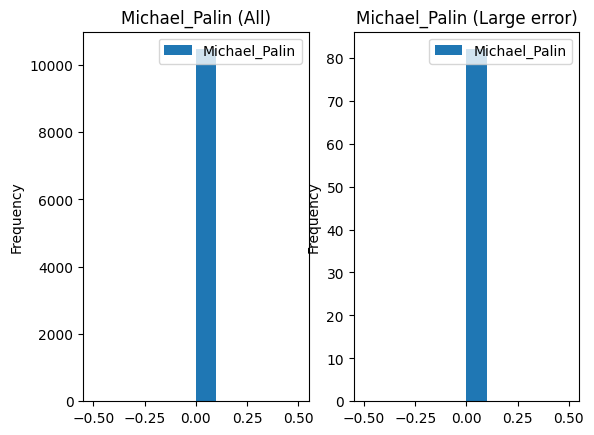

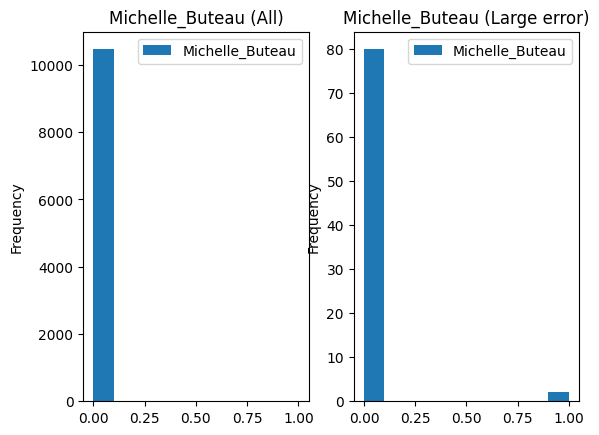

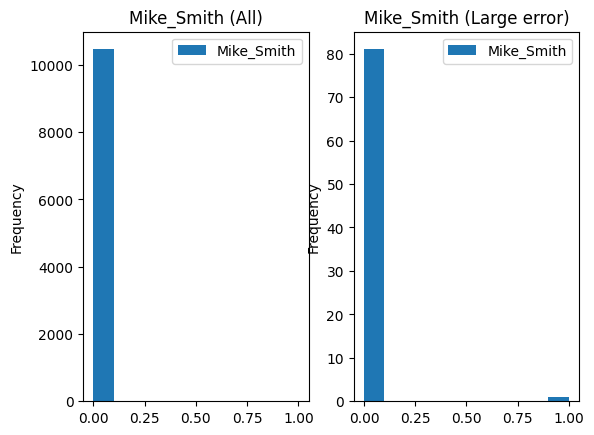

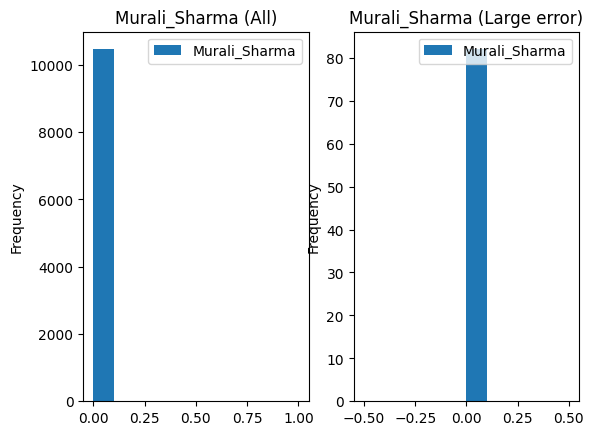

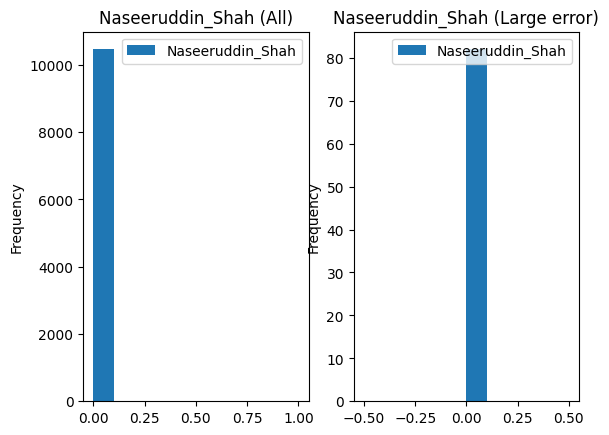

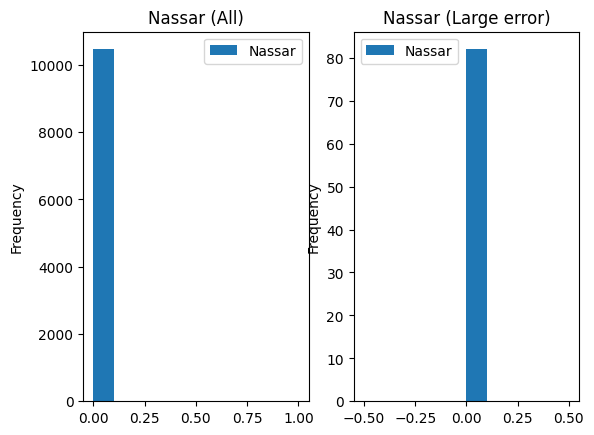

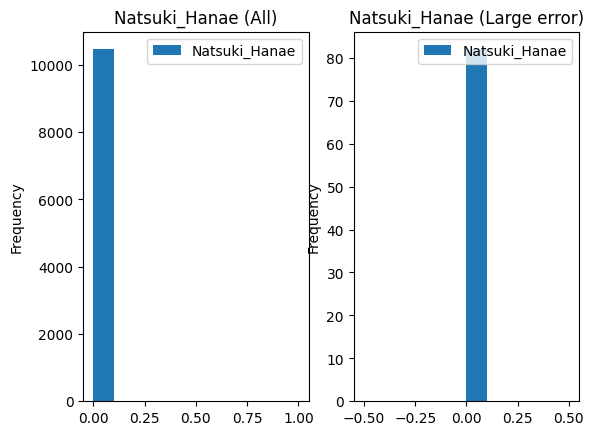

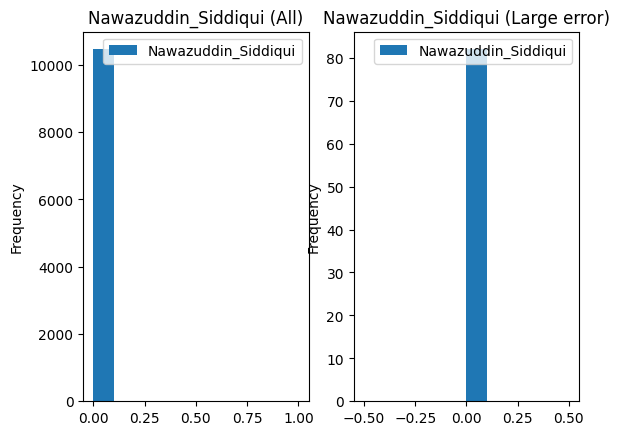

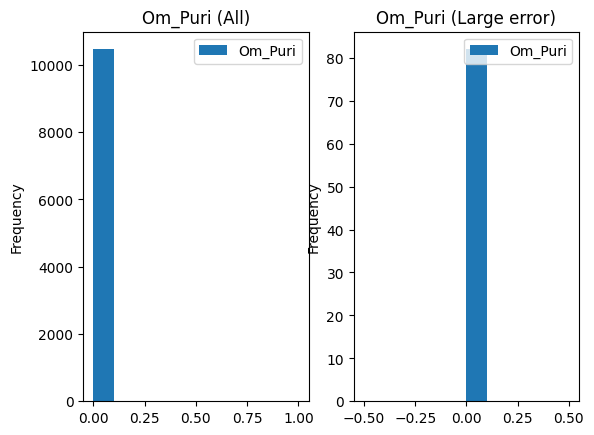

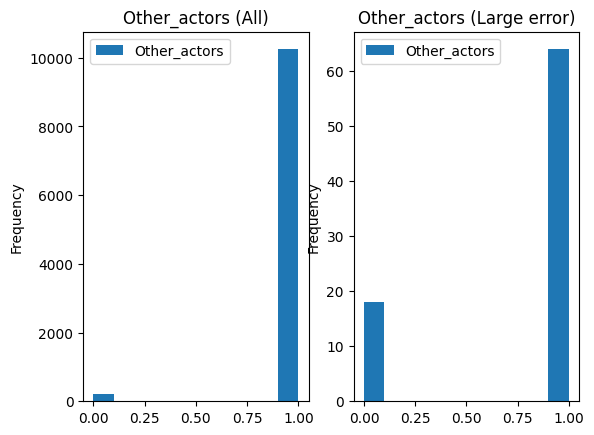

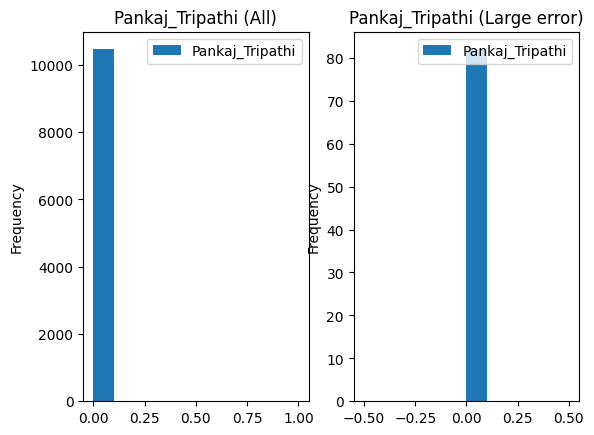

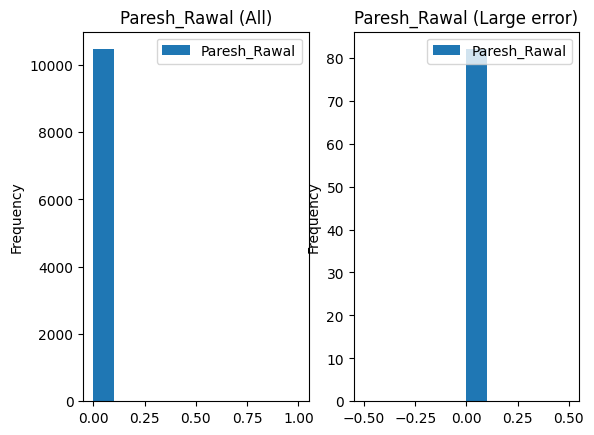

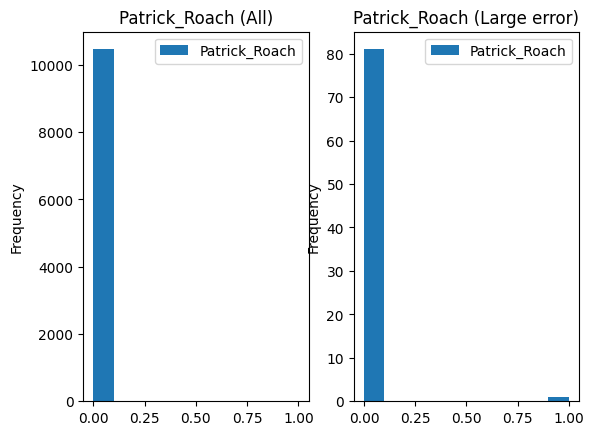

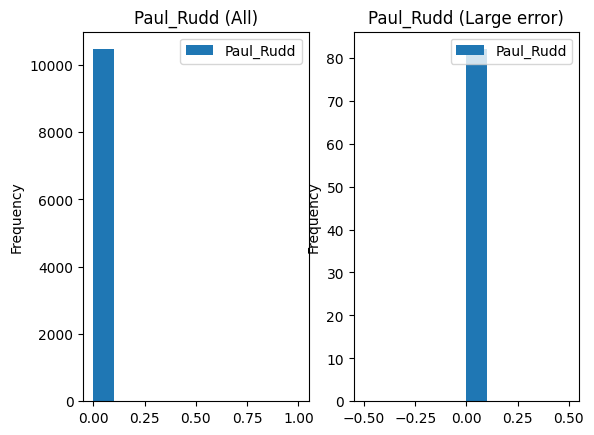

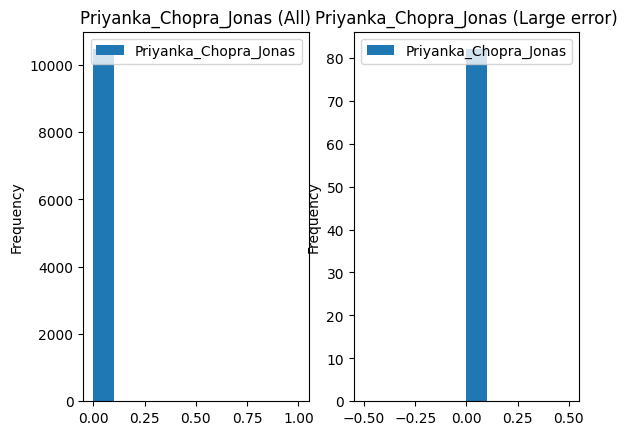

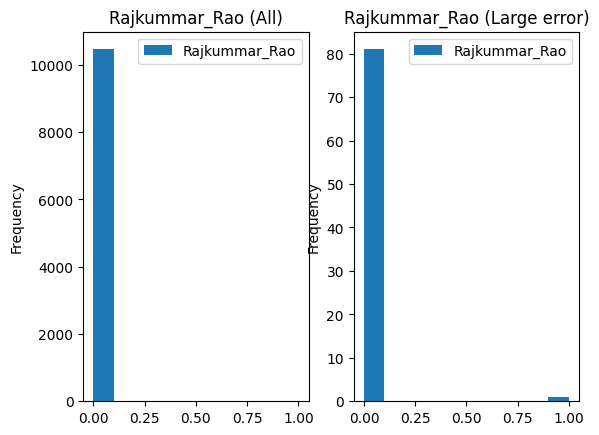

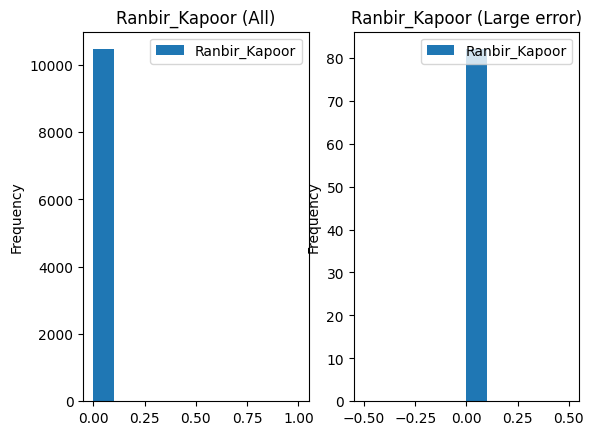

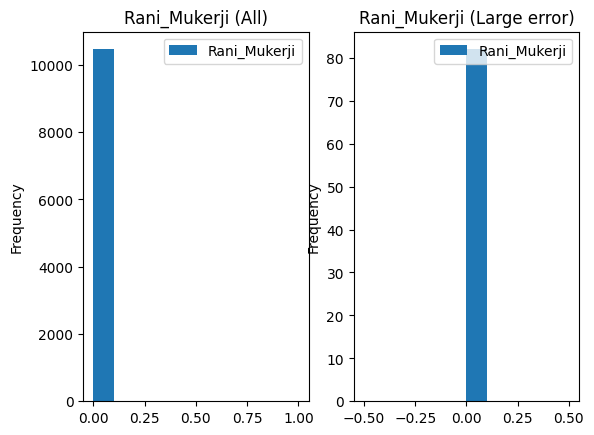

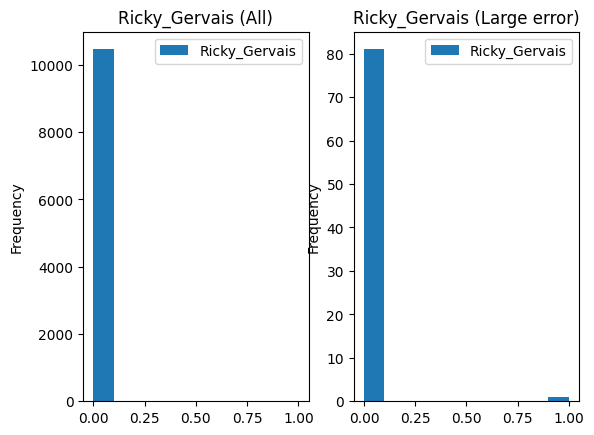

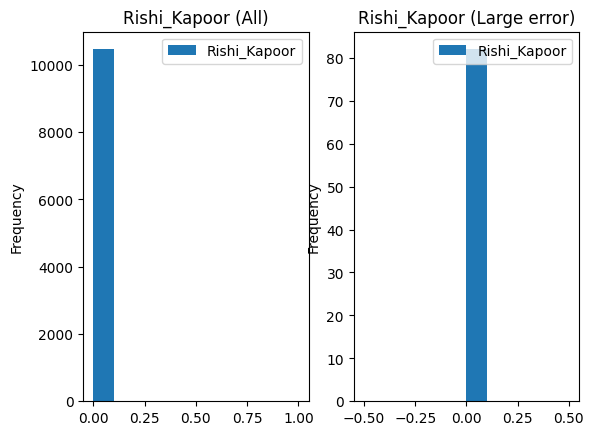

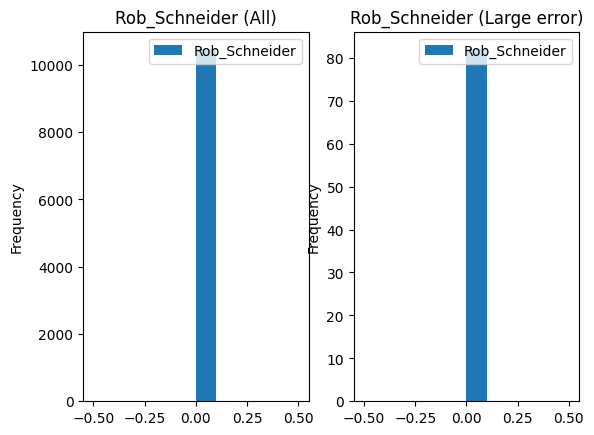

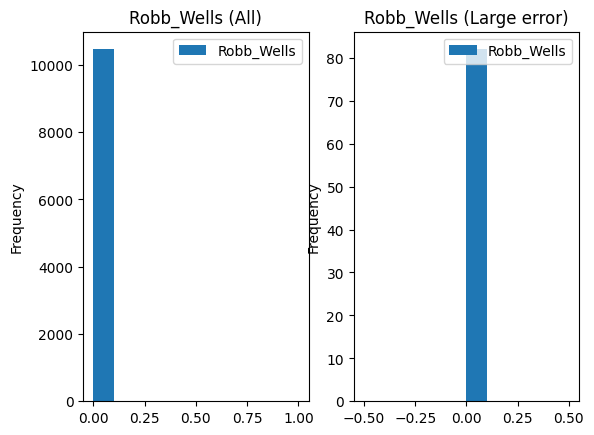

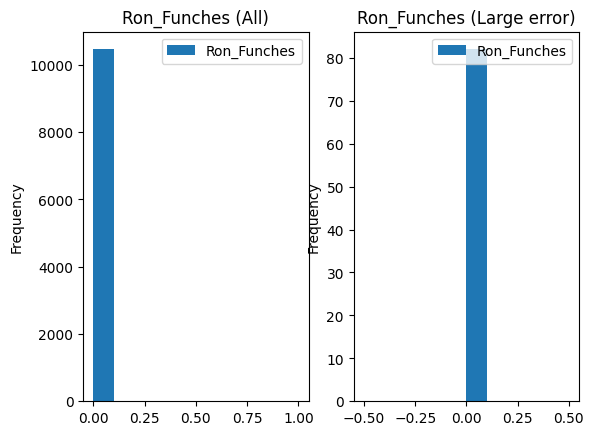

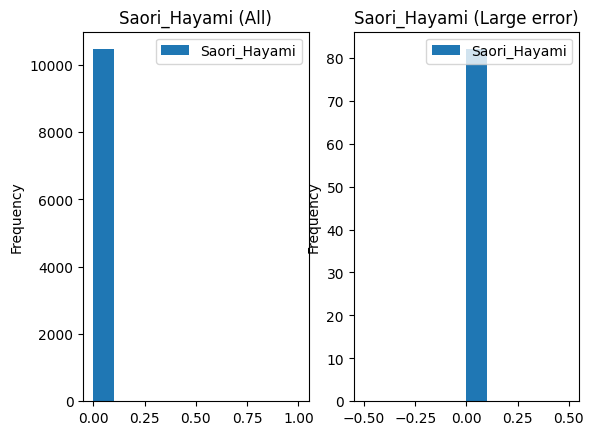

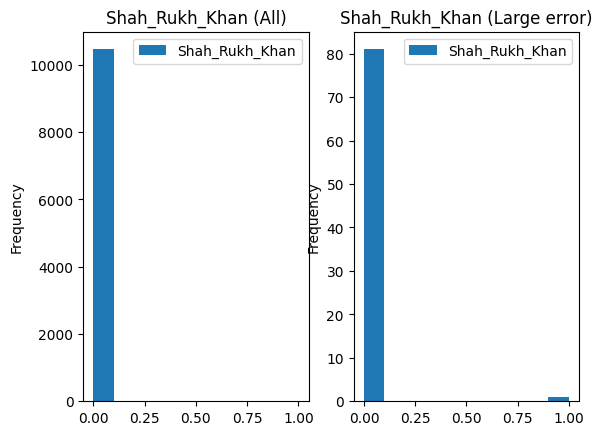

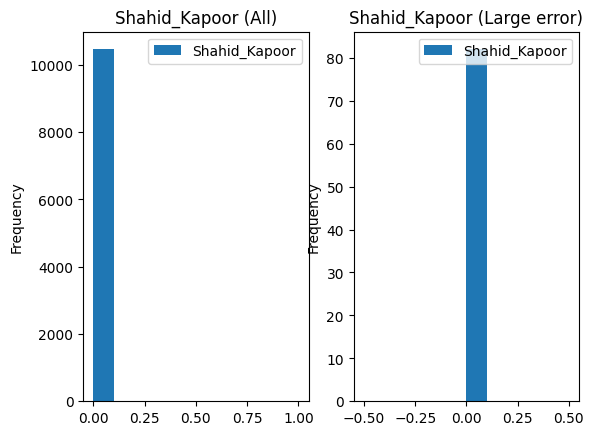

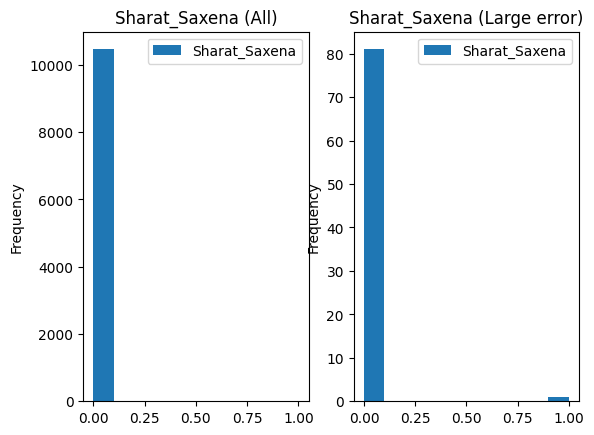

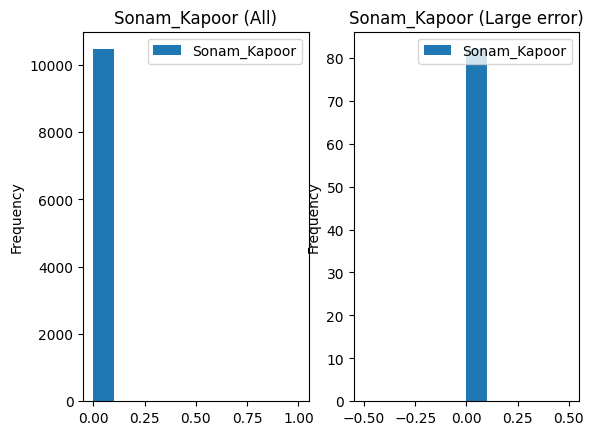

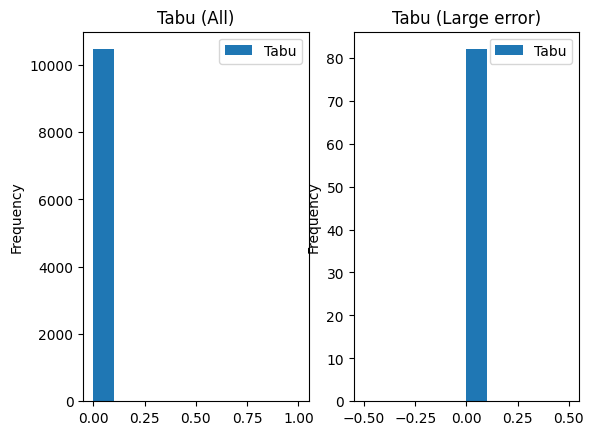

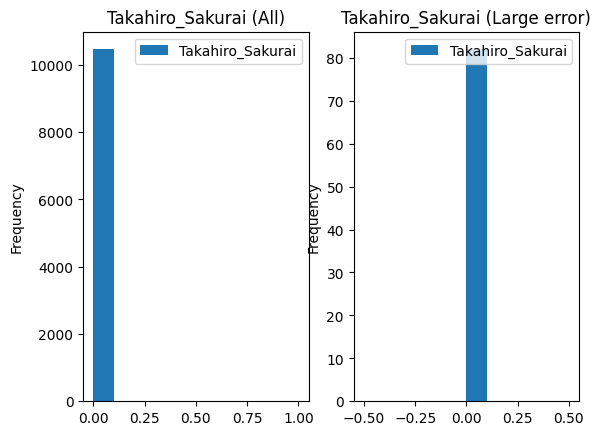

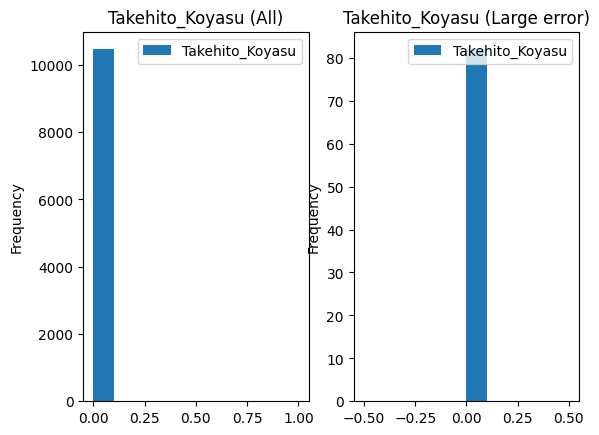

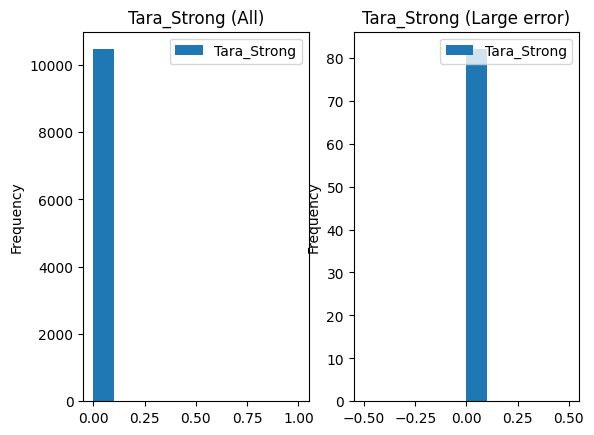

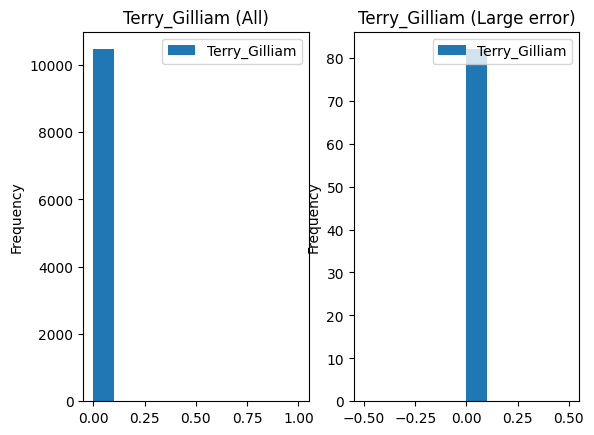

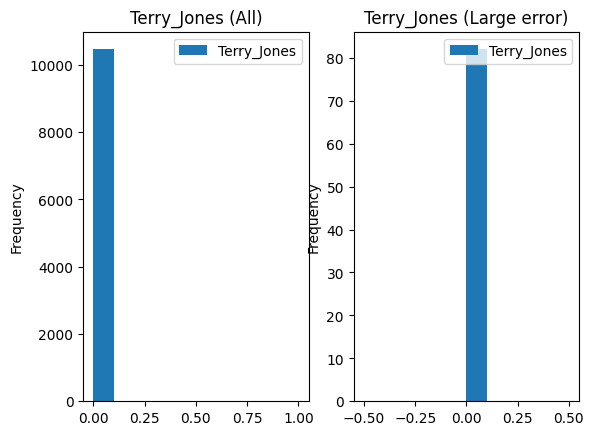

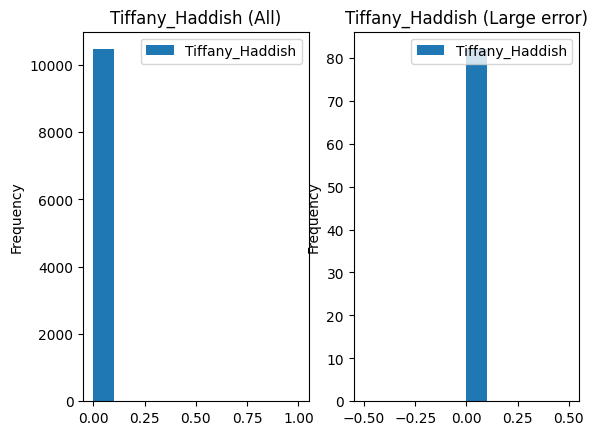

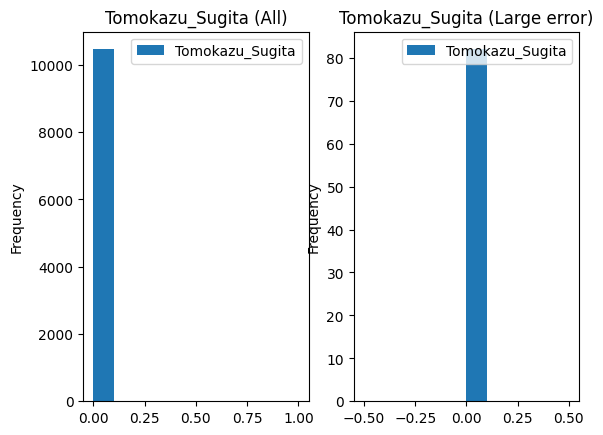

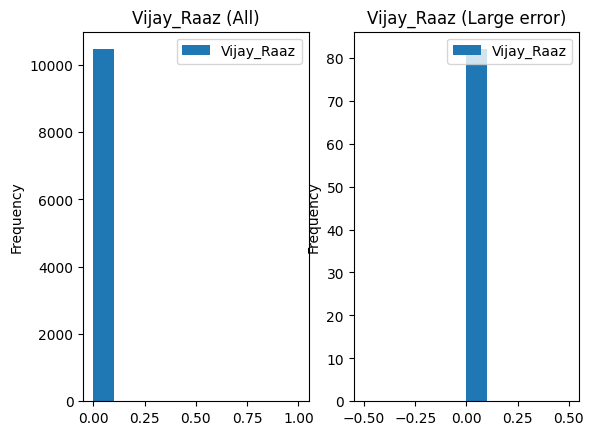

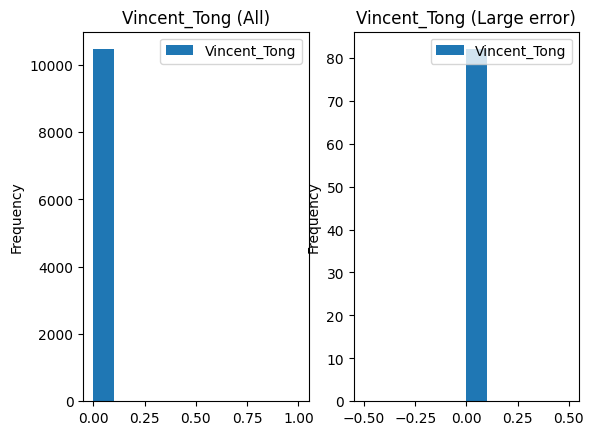

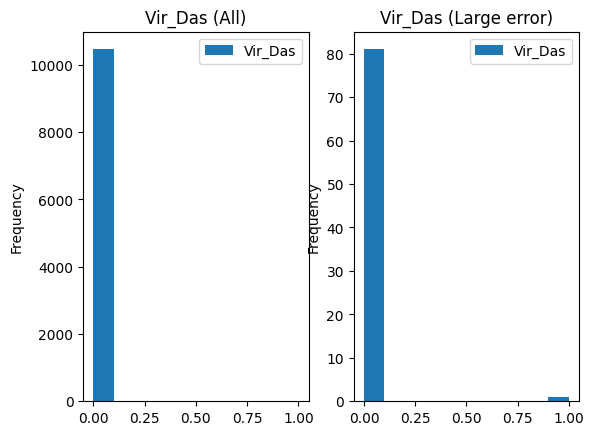

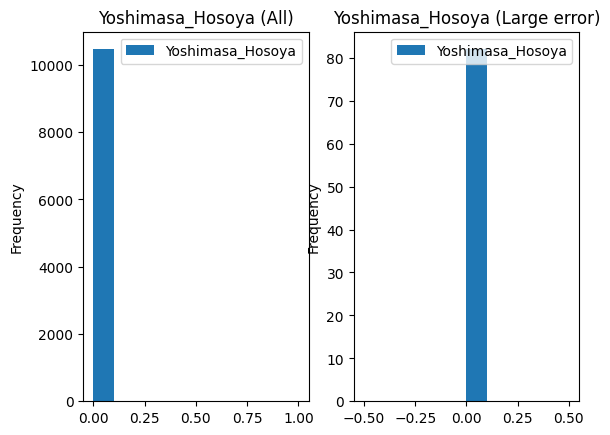

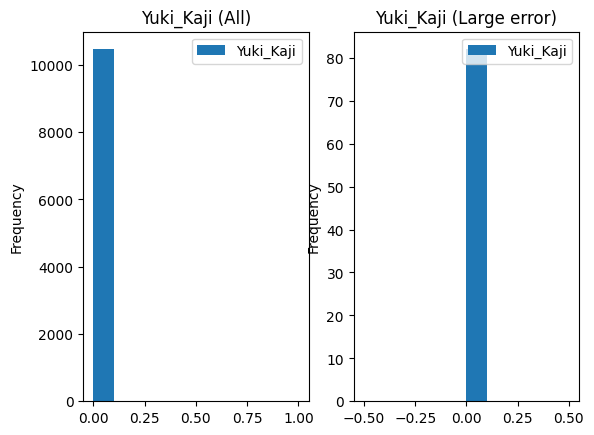

In [20]:
#Erneut erkennen wir, das unser Modell bereits sehr gut performt dennoch möchten wir uns die Fehler größer als 0,5 genauer ansehen

for column in X_test.columns:
  fig, (ax1, ax2) = plt.subplots(1, 2) # required if we want to plot multiple figures from the same cell
  df_with_predictions.plot(kind='hist', y=column, title=f'{column} (All)', ax=ax1)
  df_with_predictions[df_with_predictions.pred_diff > 0.5].plot(kind='hist', y=column, title=f'{column} (Large error)', ax=ax2)

Es scheint als habe das Modell Probleme damit unseren gewichteten imdb und tmdb Score korrekt vorherzusagen bei Filmen mit einer langen Laufzeit. Außerdem hat das Modell zum Teil Probleme mit der richtigen Vorhersage der Dummyvariablen, z. B. comedy oder Other countries.

##Modell 2 mit standardisierten Daten

Für Gradient Boosting müssen die Daten nicht zwangsläufig standardisiert werden, dennoch möchten wir testen ob es einen Einfluss auf unsere Modellgüte hat. Wir verwenden dafür die Parameter, die bei dem Hyperparameter Tuning als optimal herausgefunden wurden.

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_std = scaler.fit_transform(X)

In [22]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_std, y, test_size=0.2, random_state=42)

In [23]:
#Wir tranieren das Modell erneut mit den scalierten Daten und unseren optimalen Parametern

#{'n_estimators': 1250, 'max_depth': 7, 'learning_rate': 0.15}

gbr_sc = GradientBoostingRegressor(n_estimators=1250, learning_rate=0.15, max_depth=7)

gbr_sc.fit(X_train, y_train)

evaluate(gbr_sc, X_test_sc, y_test_sc)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


R2: -0.48428282377376597
MAE: 0.9688261818838405
MSE: 1.522520918075678
RMSE: 1.2339047443282152
MAPE: 0.15710389543708014


Unser Modell mit den nicht standardisierten Daten performt sehr schlecht.